In [1]:
import numpy as np
import xgboost as xgb
import importlib
import hist
import os
import json
import mplhep as hep
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import HH4b
from HH4b import utils
from HH4b import postprocessing
from HH4b.postprocessing.PostProcess import add_bdt_scores
from HH4b.hh_vars import txbbsfs_decorr_pt_bins, txbbsfs_decorr_txbb_wps

plt.style.use(hep.style.ROOT)
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 12})
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["grid.color"] = "#CCCCCC"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.edgecolor"] = "none"

In [2]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

In [3]:
package_path = os.path.dirname(HH4b.__file__)
legacy_label = "Legacy"
mass_var = "H2PNetMass"
bdt_model_name = "24May31_lr_0p02_md_8_AK4Away"
bdt_config = "24May31_lr_0p02_md_8_AK4Away"


def get_dataframe(events_dict, year, bdt_model_name, bdt_config):
    bdt_model = xgb.XGBClassifier()
    bdt_model.load_model(
        fname=f"{package_path}/boosted/bdt_trainings_run3/{bdt_model_name}/trained_bdt.model"
    )
    make_bdt_dataframe = importlib.import_module(
        f".{bdt_config}", package="HH4b.boosted.bdt_trainings_run3"
    )

    bdt_events_dict = {}
    for key in events_dict:
        events = events_dict[key]
        bdt_events = make_bdt_dataframe.bdt_dataframe(events)
        preds = bdt_model.predict_proba(bdt_events)
        # inference
        add_bdt_scores(bdt_events, preds)

        # extra variables
        bdt_events["H1PNetMass"] = events["bbFatJetPNetMassLegacy"][0]
        bdt_events["H2PNetMass"] = events["bbFatJetPNetMassLegacy"][1]
        bdt_events["H1Msd"] = events["bbFatJetMsd"][0]
        bdt_events["H1TXbb"] = events[f"bbFatJetPNetTXbb{legacy_label}"][0]
        bdt_events["H2TXbb"] = events[f"bbFatJetPNetTXbb{legacy_label}"][1]
        bdt_events["weight"] = events["finalWeight"].to_numpy()

        bdt_events["hlt"] = np.any(
            np.array(
                [events[trigger][0] for trigger in postprocessing.HLTs[year] if trigger in events]
            ),
            axis=0,
        )
        mask_hlt = bdt_events["hlt"] == 1

        # masks
        mask_presel = (
            (bdt_events["H1Msd"] > 40)
            & (bdt_events["H1Pt"] > 300)
            & (bdt_events["H2Pt"] > 250)
            & (bdt_events["H1TXbb"] > 0.8)
        )
        mask_mass = (bdt_events["H2PNetMass"] > 50) & (bdt_events["H2PNetMass"] < 250)
        bdt_events = bdt_events[(mask_mass) & (mask_hlt) & (mask_presel)]

        columns = [
            "bdt_score",
            "bdt_score_vbf",
            "H1TXbb",
            "H2TXbb",
            "H1PNetMass",
            "H2PNetMass",
            "weight",
            "H1Pt",
            "H2Pt",
        ]
        bdt_events_dict[key] = bdt_events[columns]
    return bdt_events_dict

In [4]:
data_dir = "24May24_v12_private_signal"
input_dir = f"/ceph/cms/store/user/cmantill/bbbb/skimmer/{data_dir}"

samples_run3 = {
    "2022EE": {
        "hh4b": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV?"],
        "vbfhh4b": ["VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8?"],
        "data": [f"JetMET_Run"],
    },
    "2022": {
        "hh4b": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV?"],
        "vbfhh4b": ["VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8?"],
    },
    "2023": {
        "hh4b": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV?"],
        "vbfhh4b": ["VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8?"],
    },
    "2023BPix": {
        "hh4b": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV?"],
        "vbfhh4b": ["VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8?"],
    },
}

bdt_events_dict_year = {}
for year in samples_run3:
    events = HH4b.postprocessing.load_run3_samples(
        input_dir=input_dir,
        year=year,
        legacy=True,
        samples_run3=samples_run3,
        reorder_txbb=True,
        txbb=f"bbFatJetPNetTXbb{legacy_label}",
    )
    bdt_events_dict_year[year] = get_dataframe(events, year, bdt_model_name, bdt_config)

Loading JetMET_Run2022G
Loaded JetMET_Run2022G                                   : 261651 entries
Loading JetMET_Run2022F
Loaded JetMET_Run2022F                                   : 1666897 entries
Loading JetMET_Run2022E
Loaded JetMET_Run2022E                                   : 426191 entries
Loading GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV
Loaded GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV: 155470 entries
Loading VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8
Loaded VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8: 20338 entries
scaling and smearing mass for hh4b 2022EE
scaling and smearing mass for vbfhh4b 2022EE
Loading GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV
Loaded GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV: 48963 entries
Loading VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8
Loaded VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8: 6739 entries
scaling and smearing mass for hh4b 2022
sc

In [8]:
events_combined, scaled_by = postprocessing.combine_run3_samples(
    bdt_events_dict_year,
    ["hh4b", "vbfhh4b", "data"],
    bg_keys=["ttbar"],
    scale_processes={},
    years_run3=bdt_events_dict_year.keys(),
)

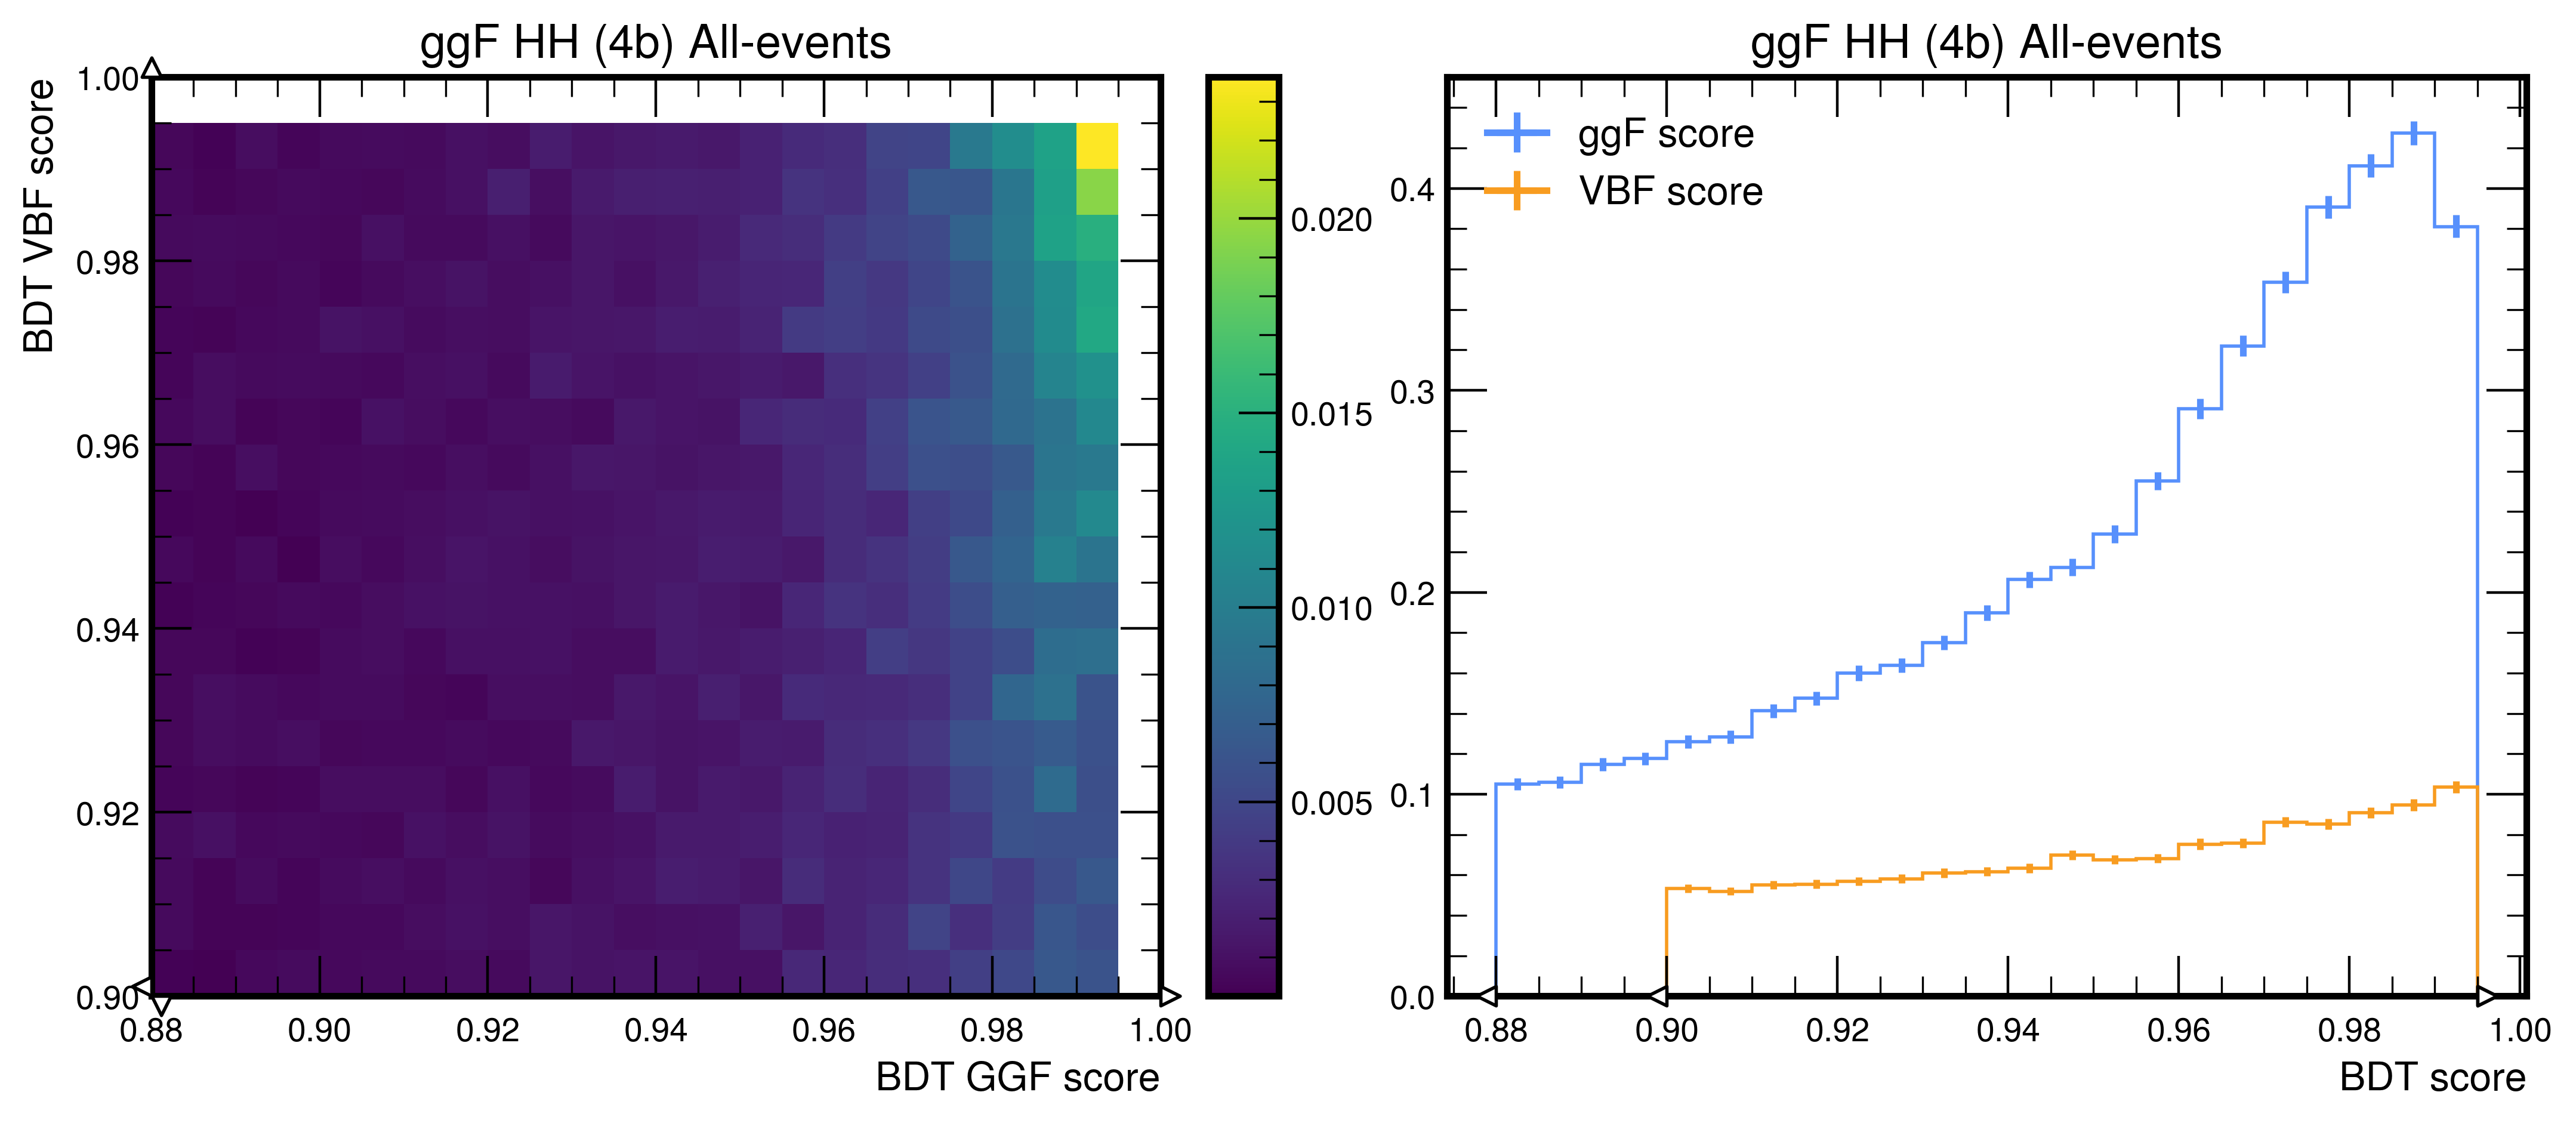

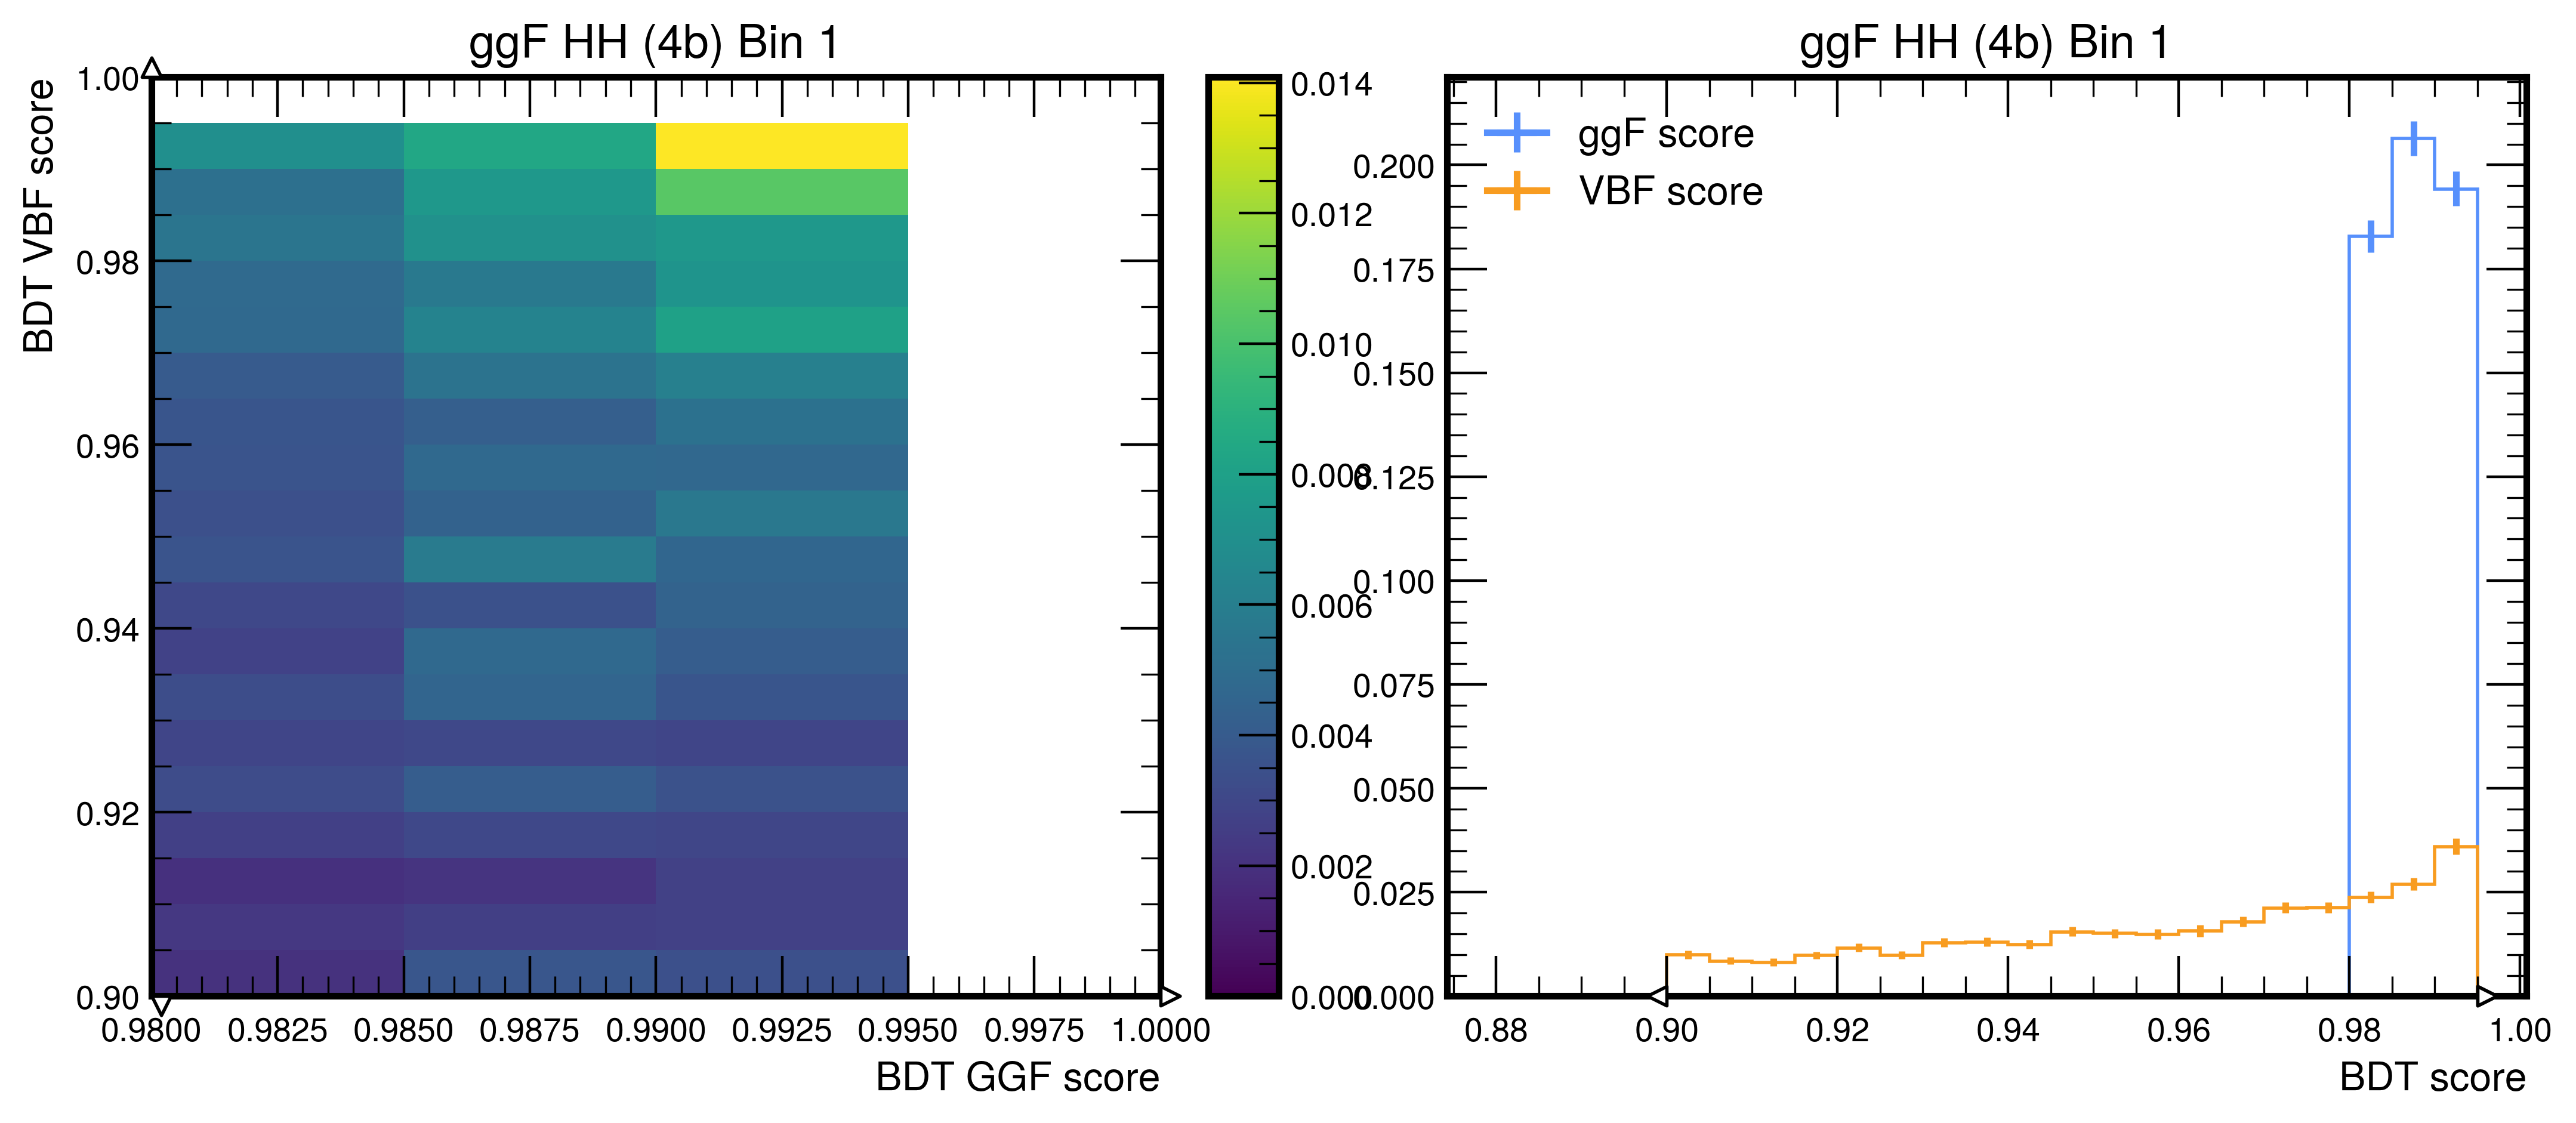

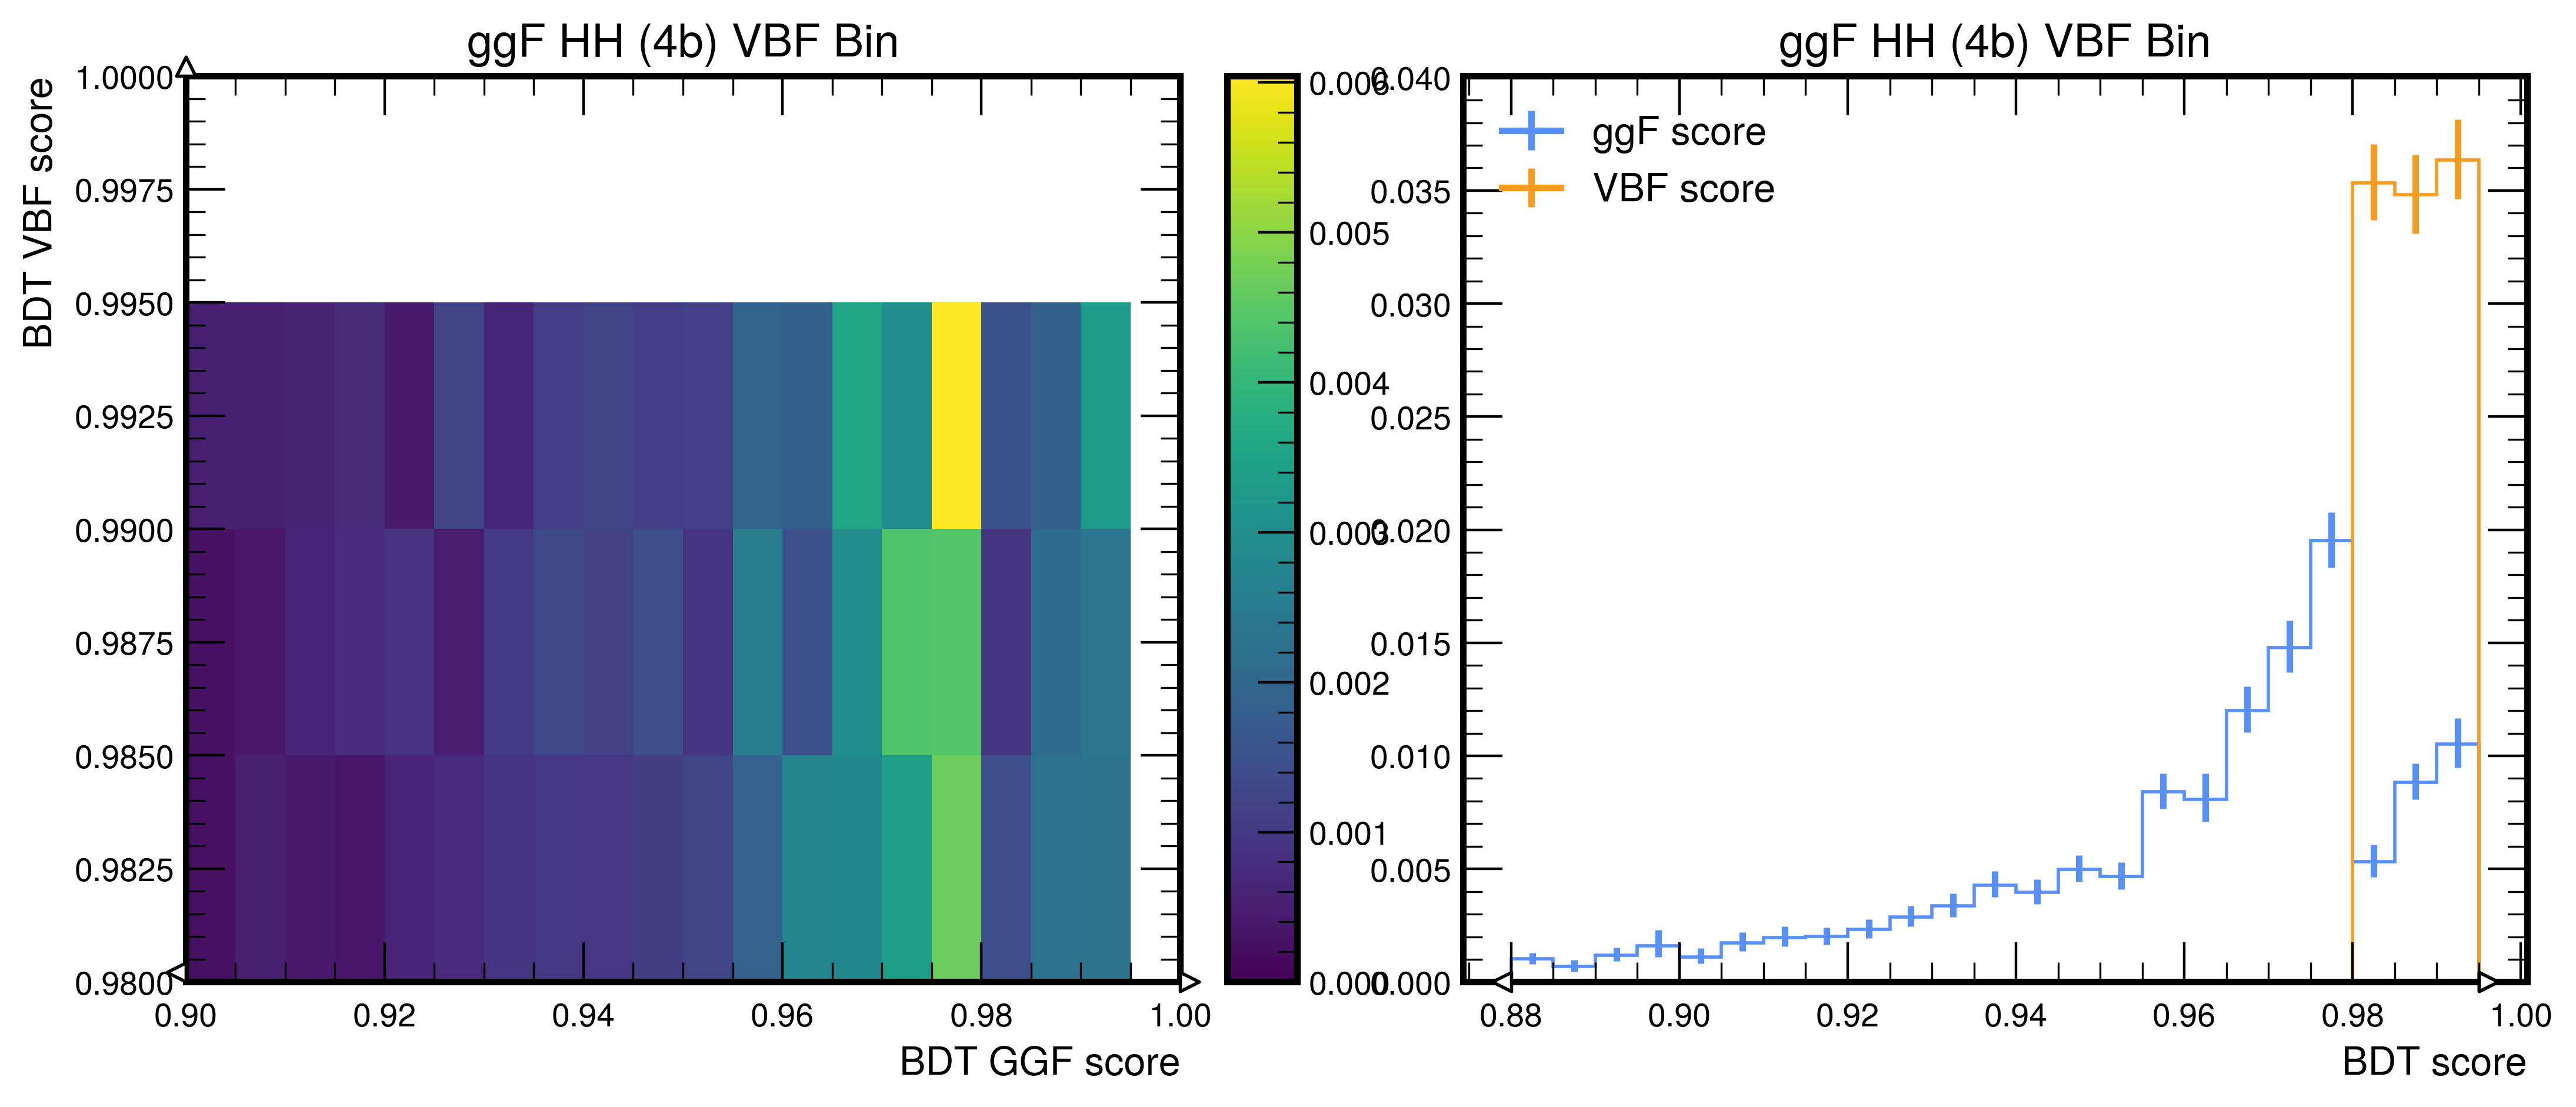

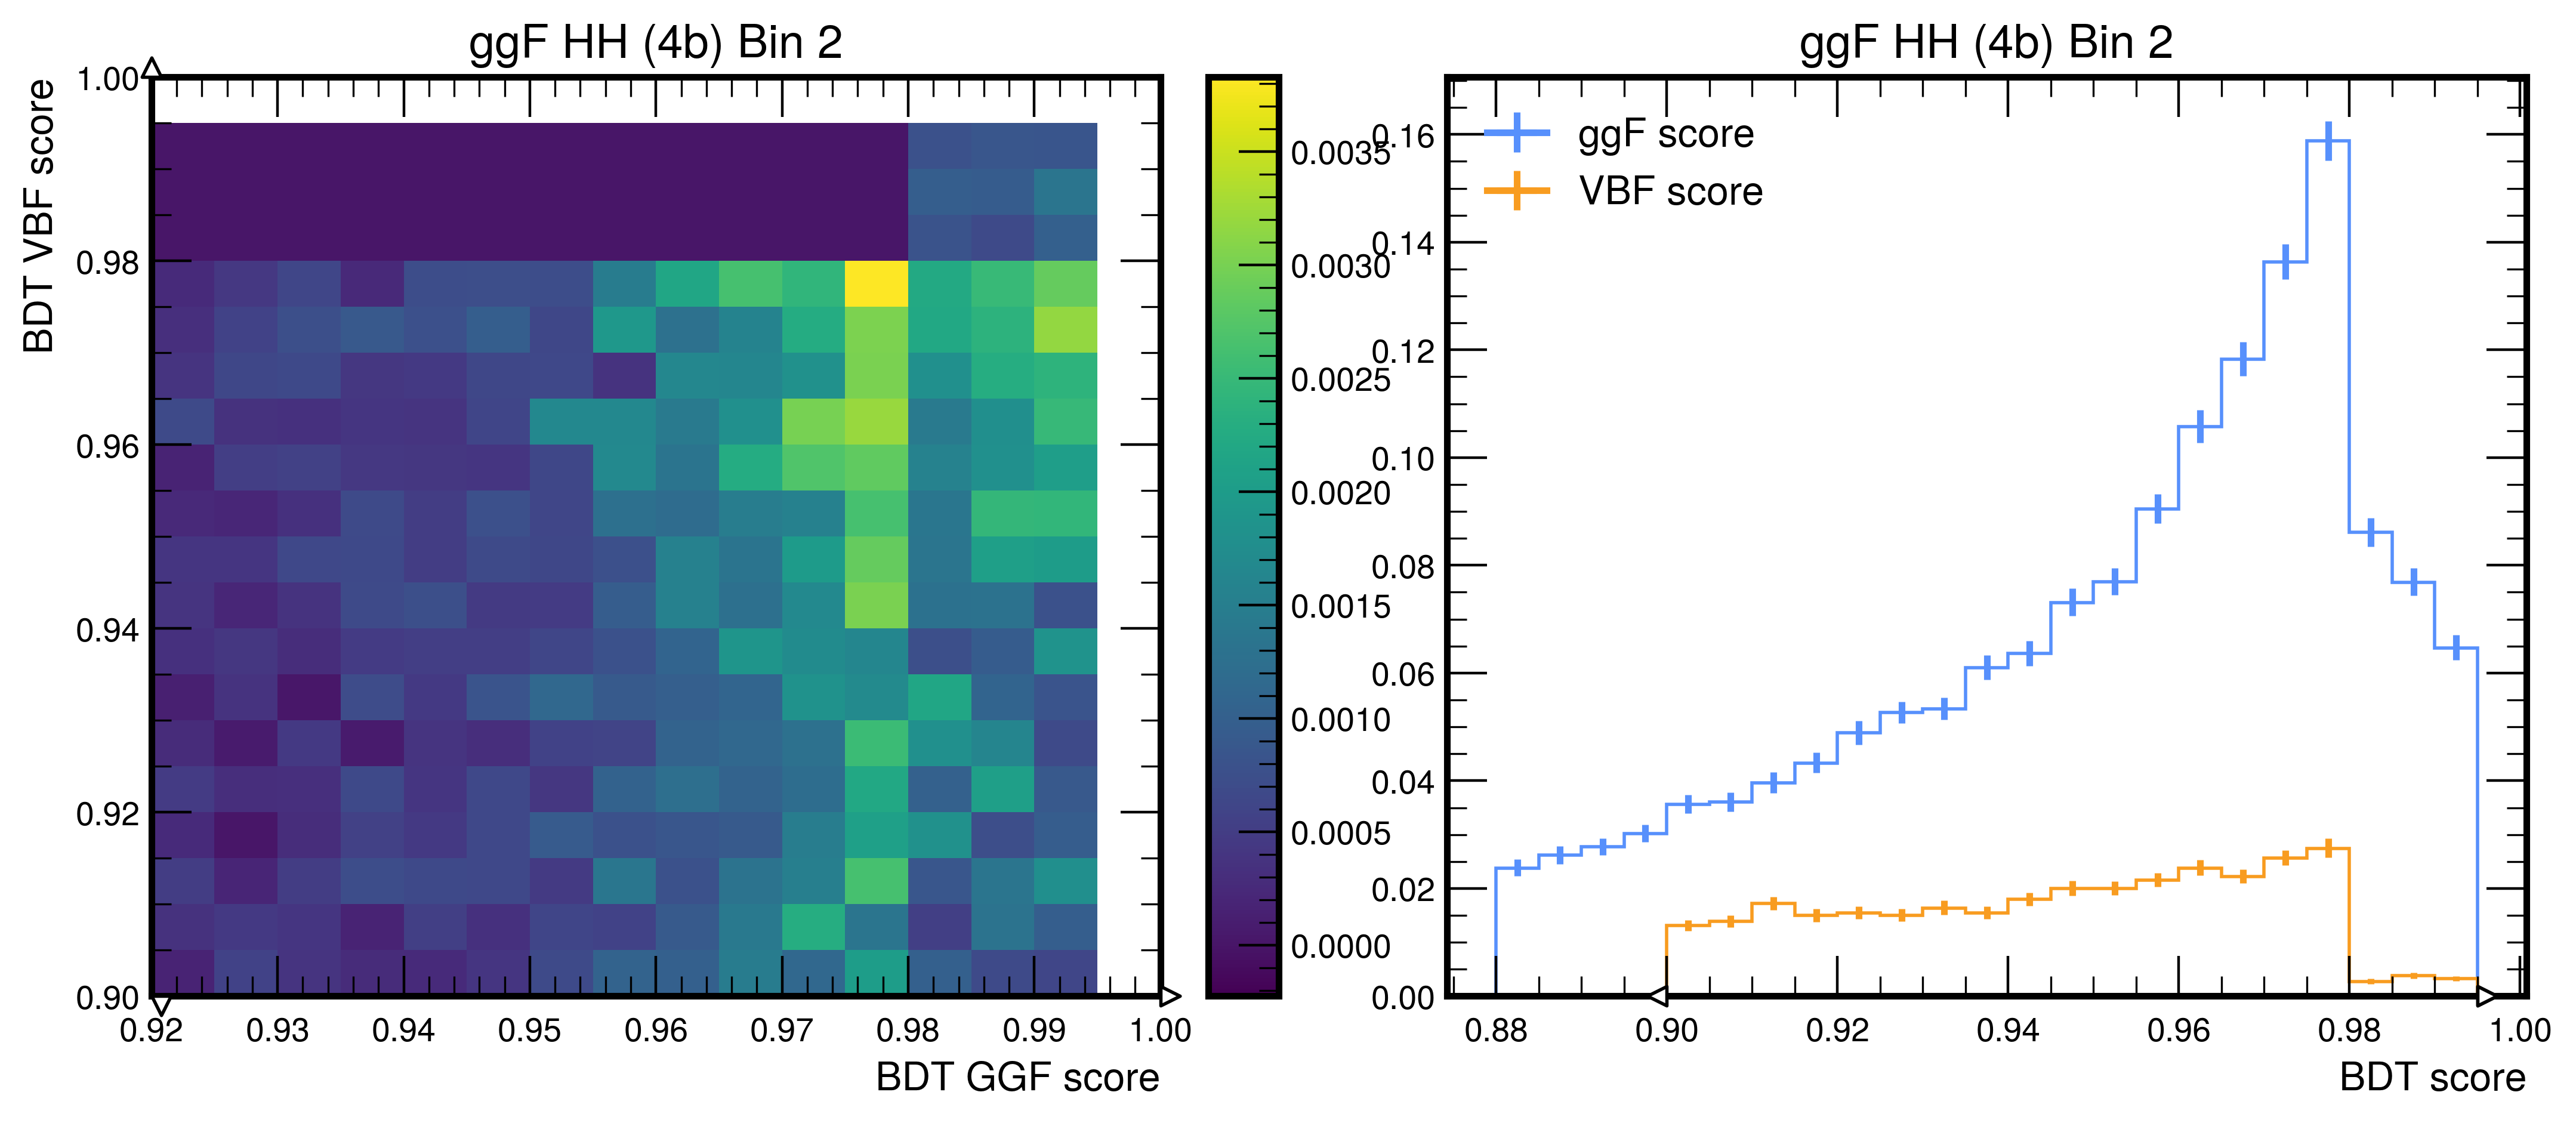

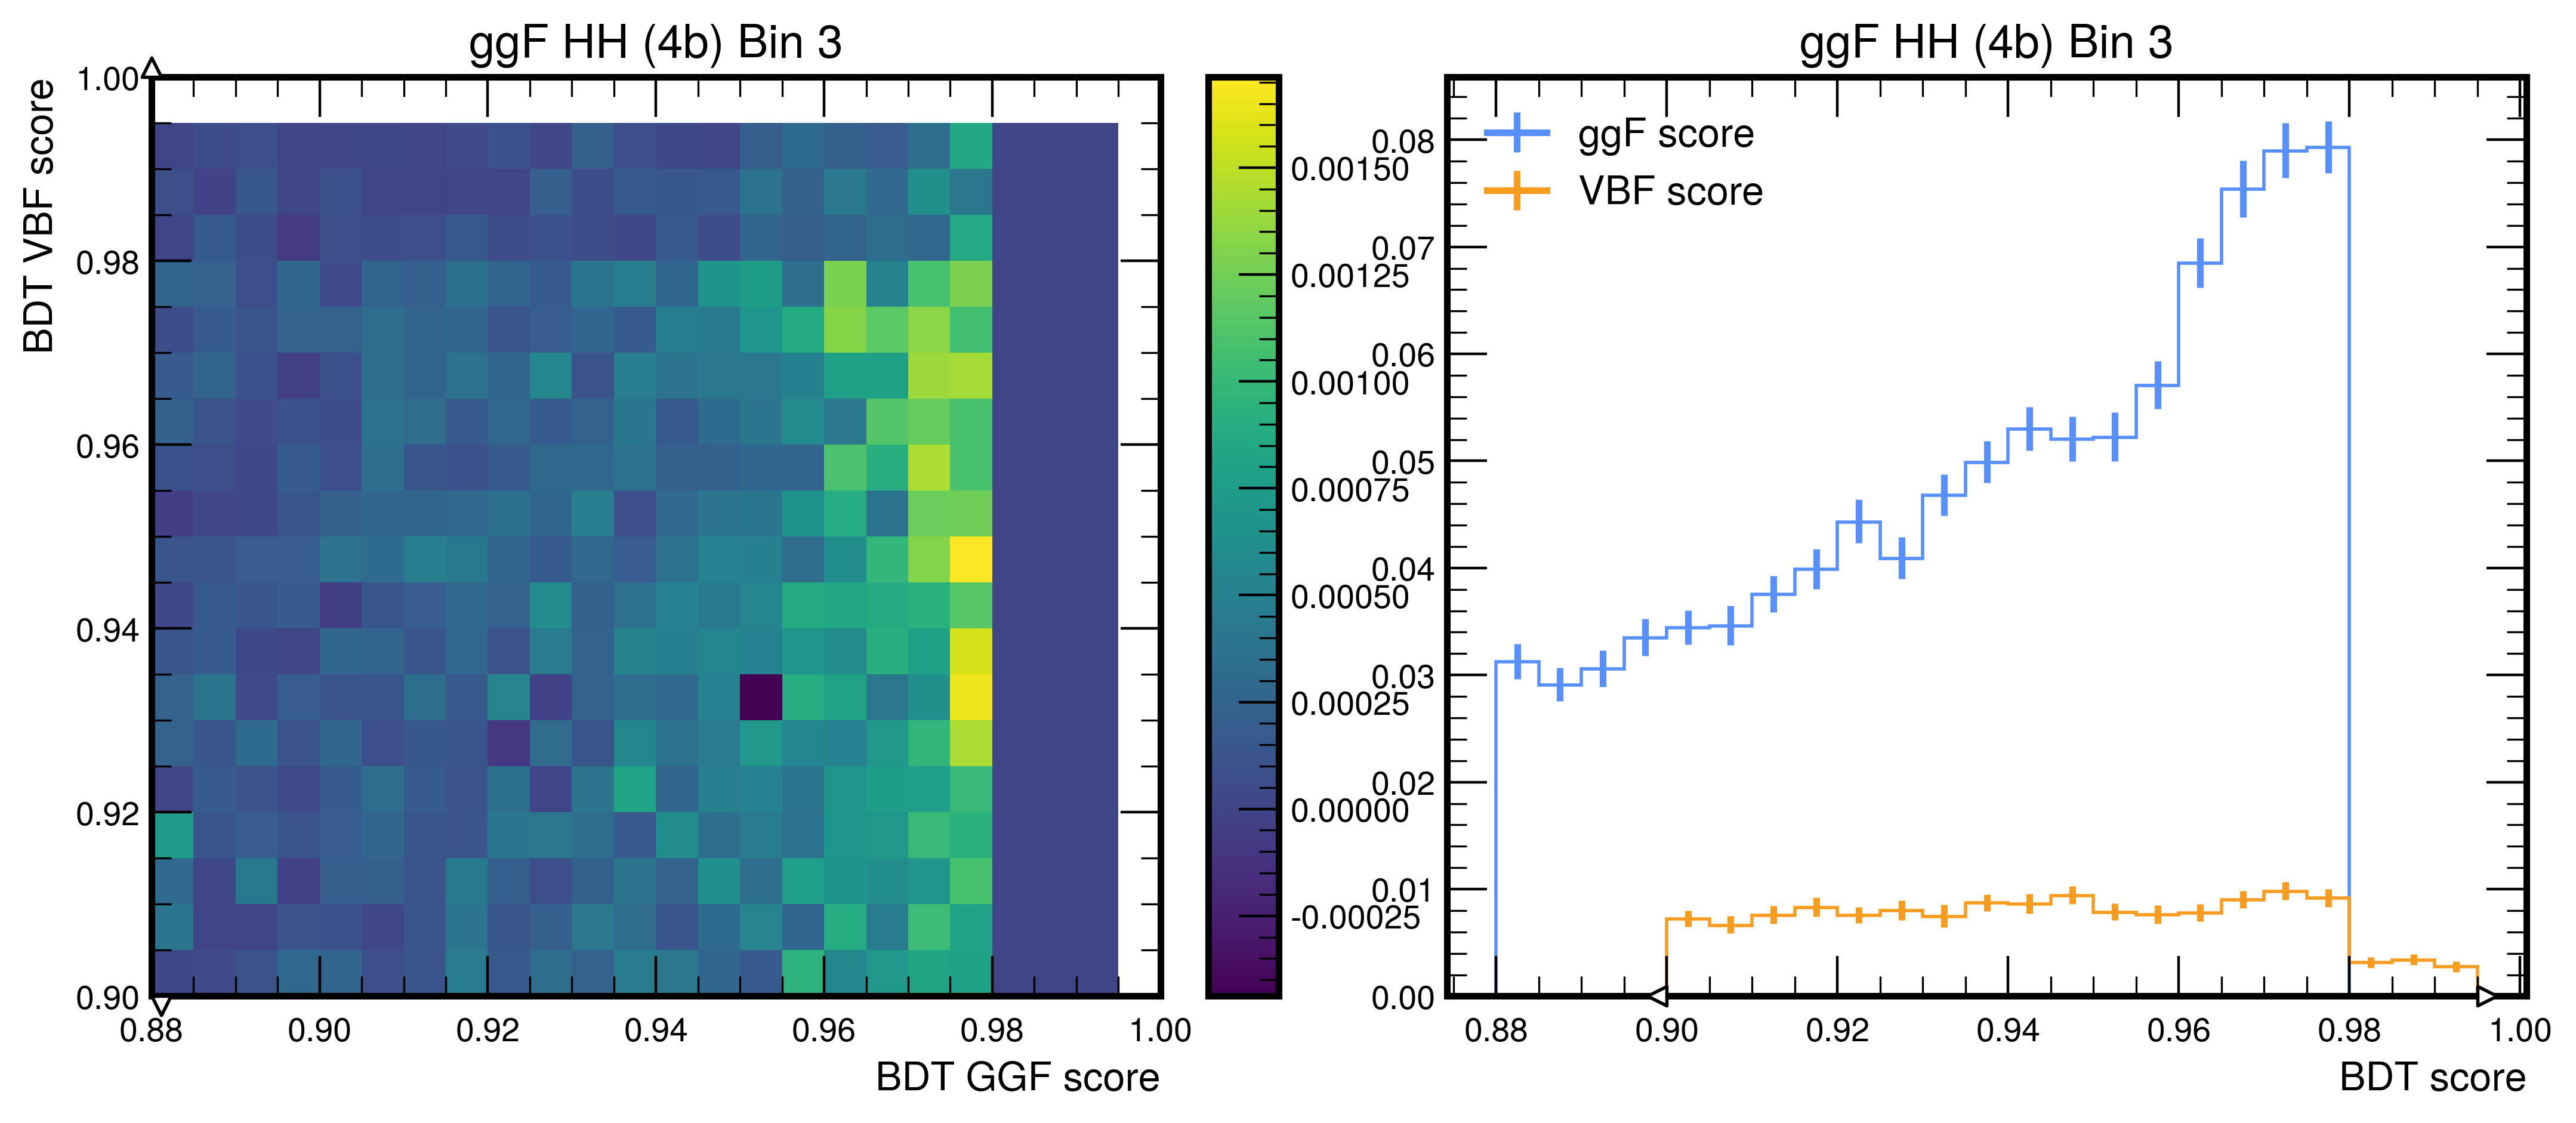

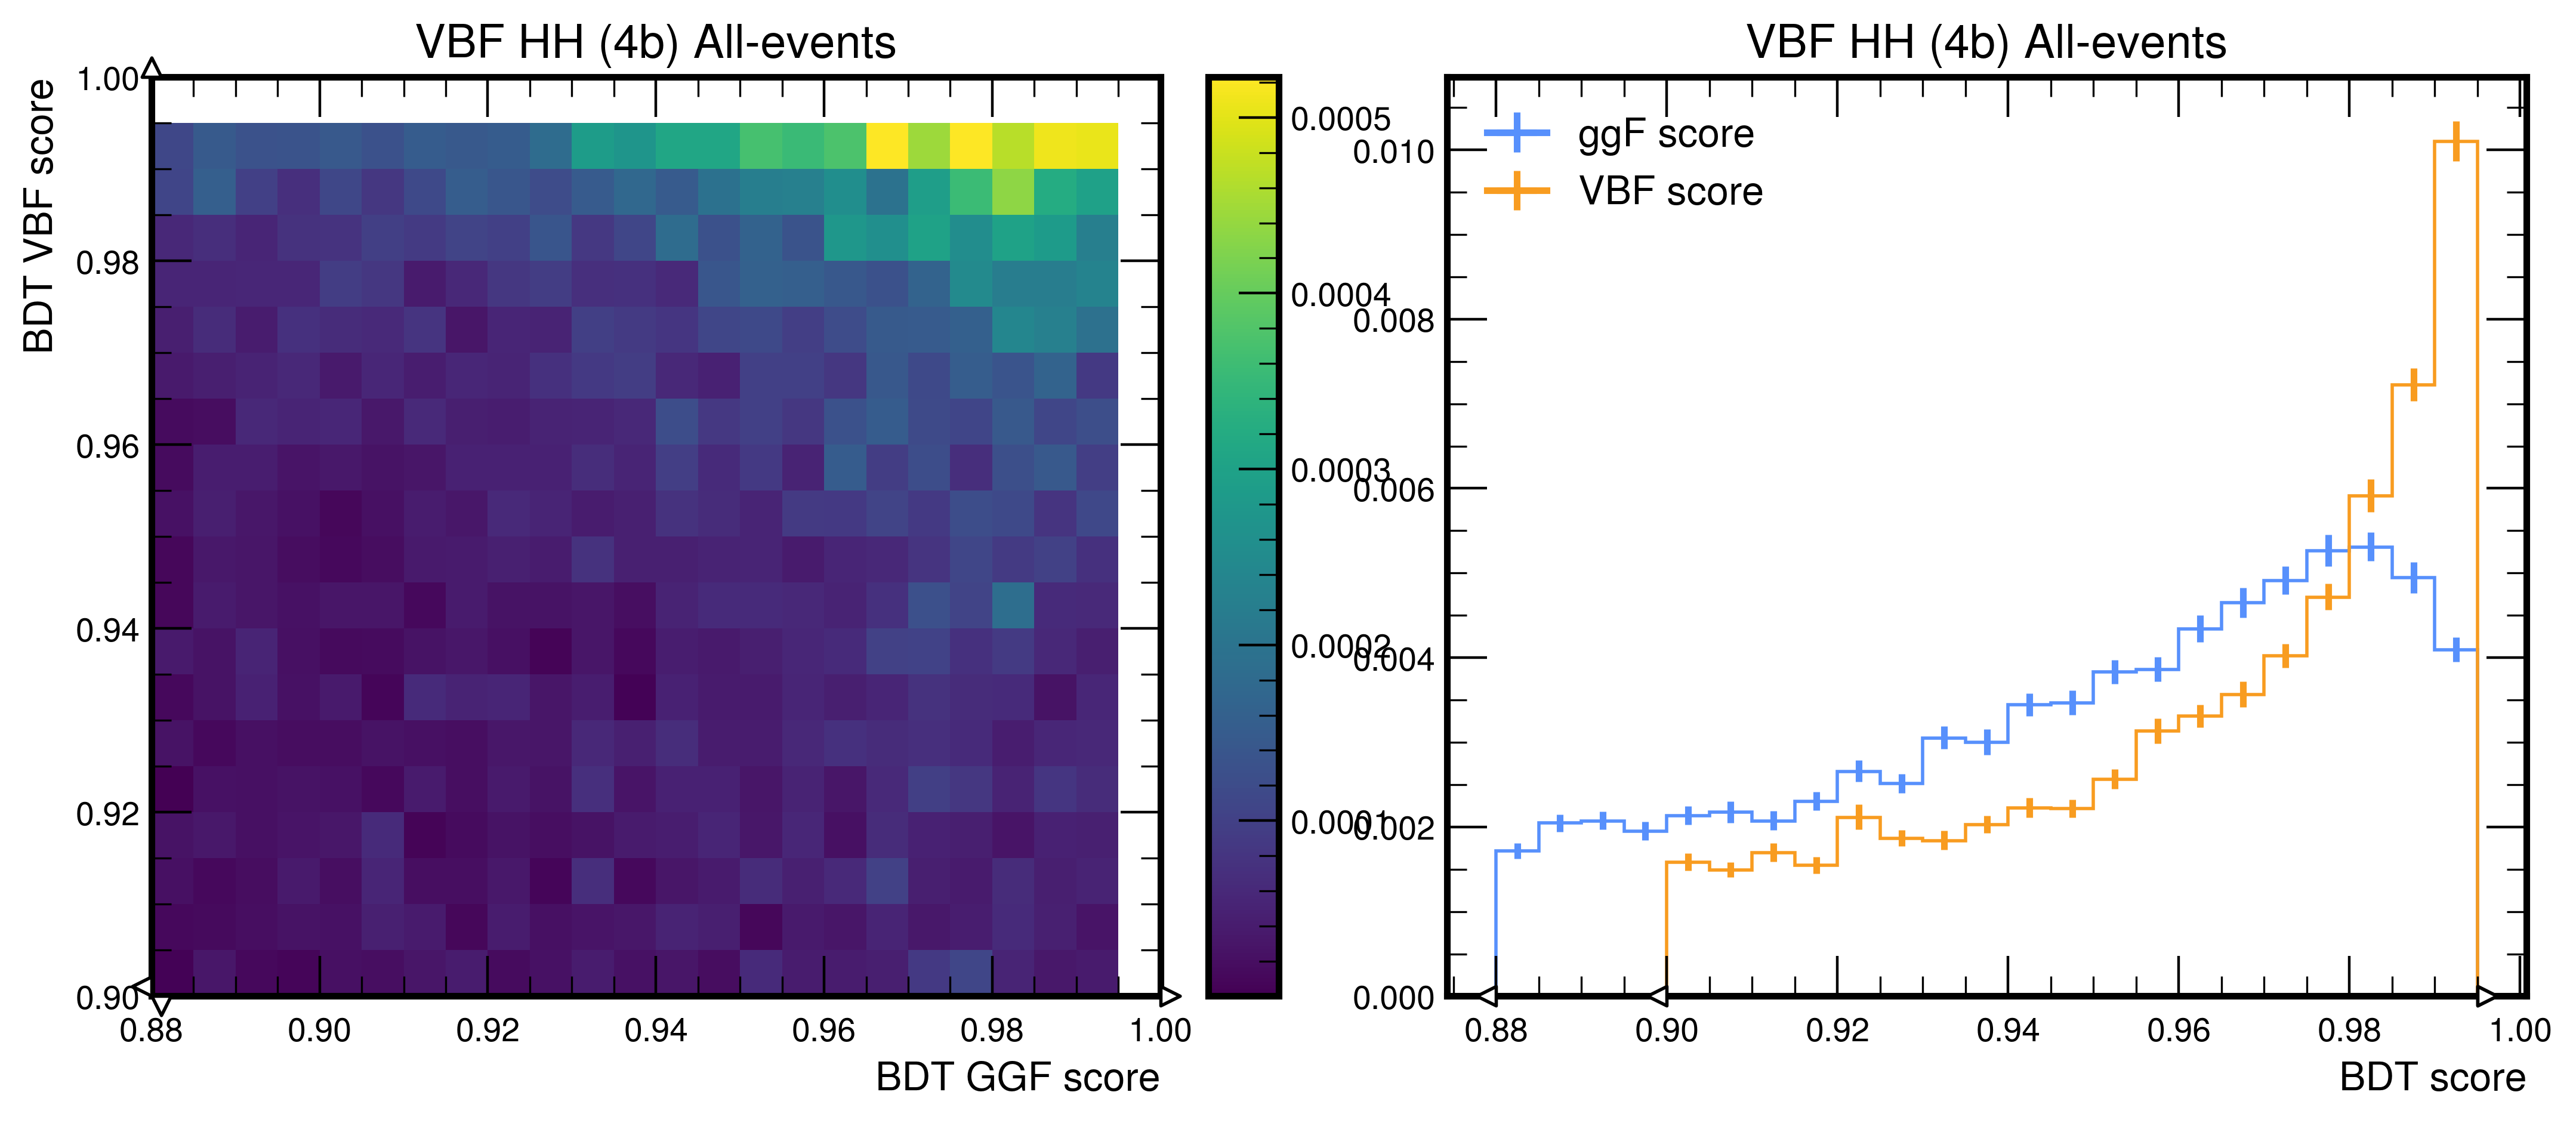

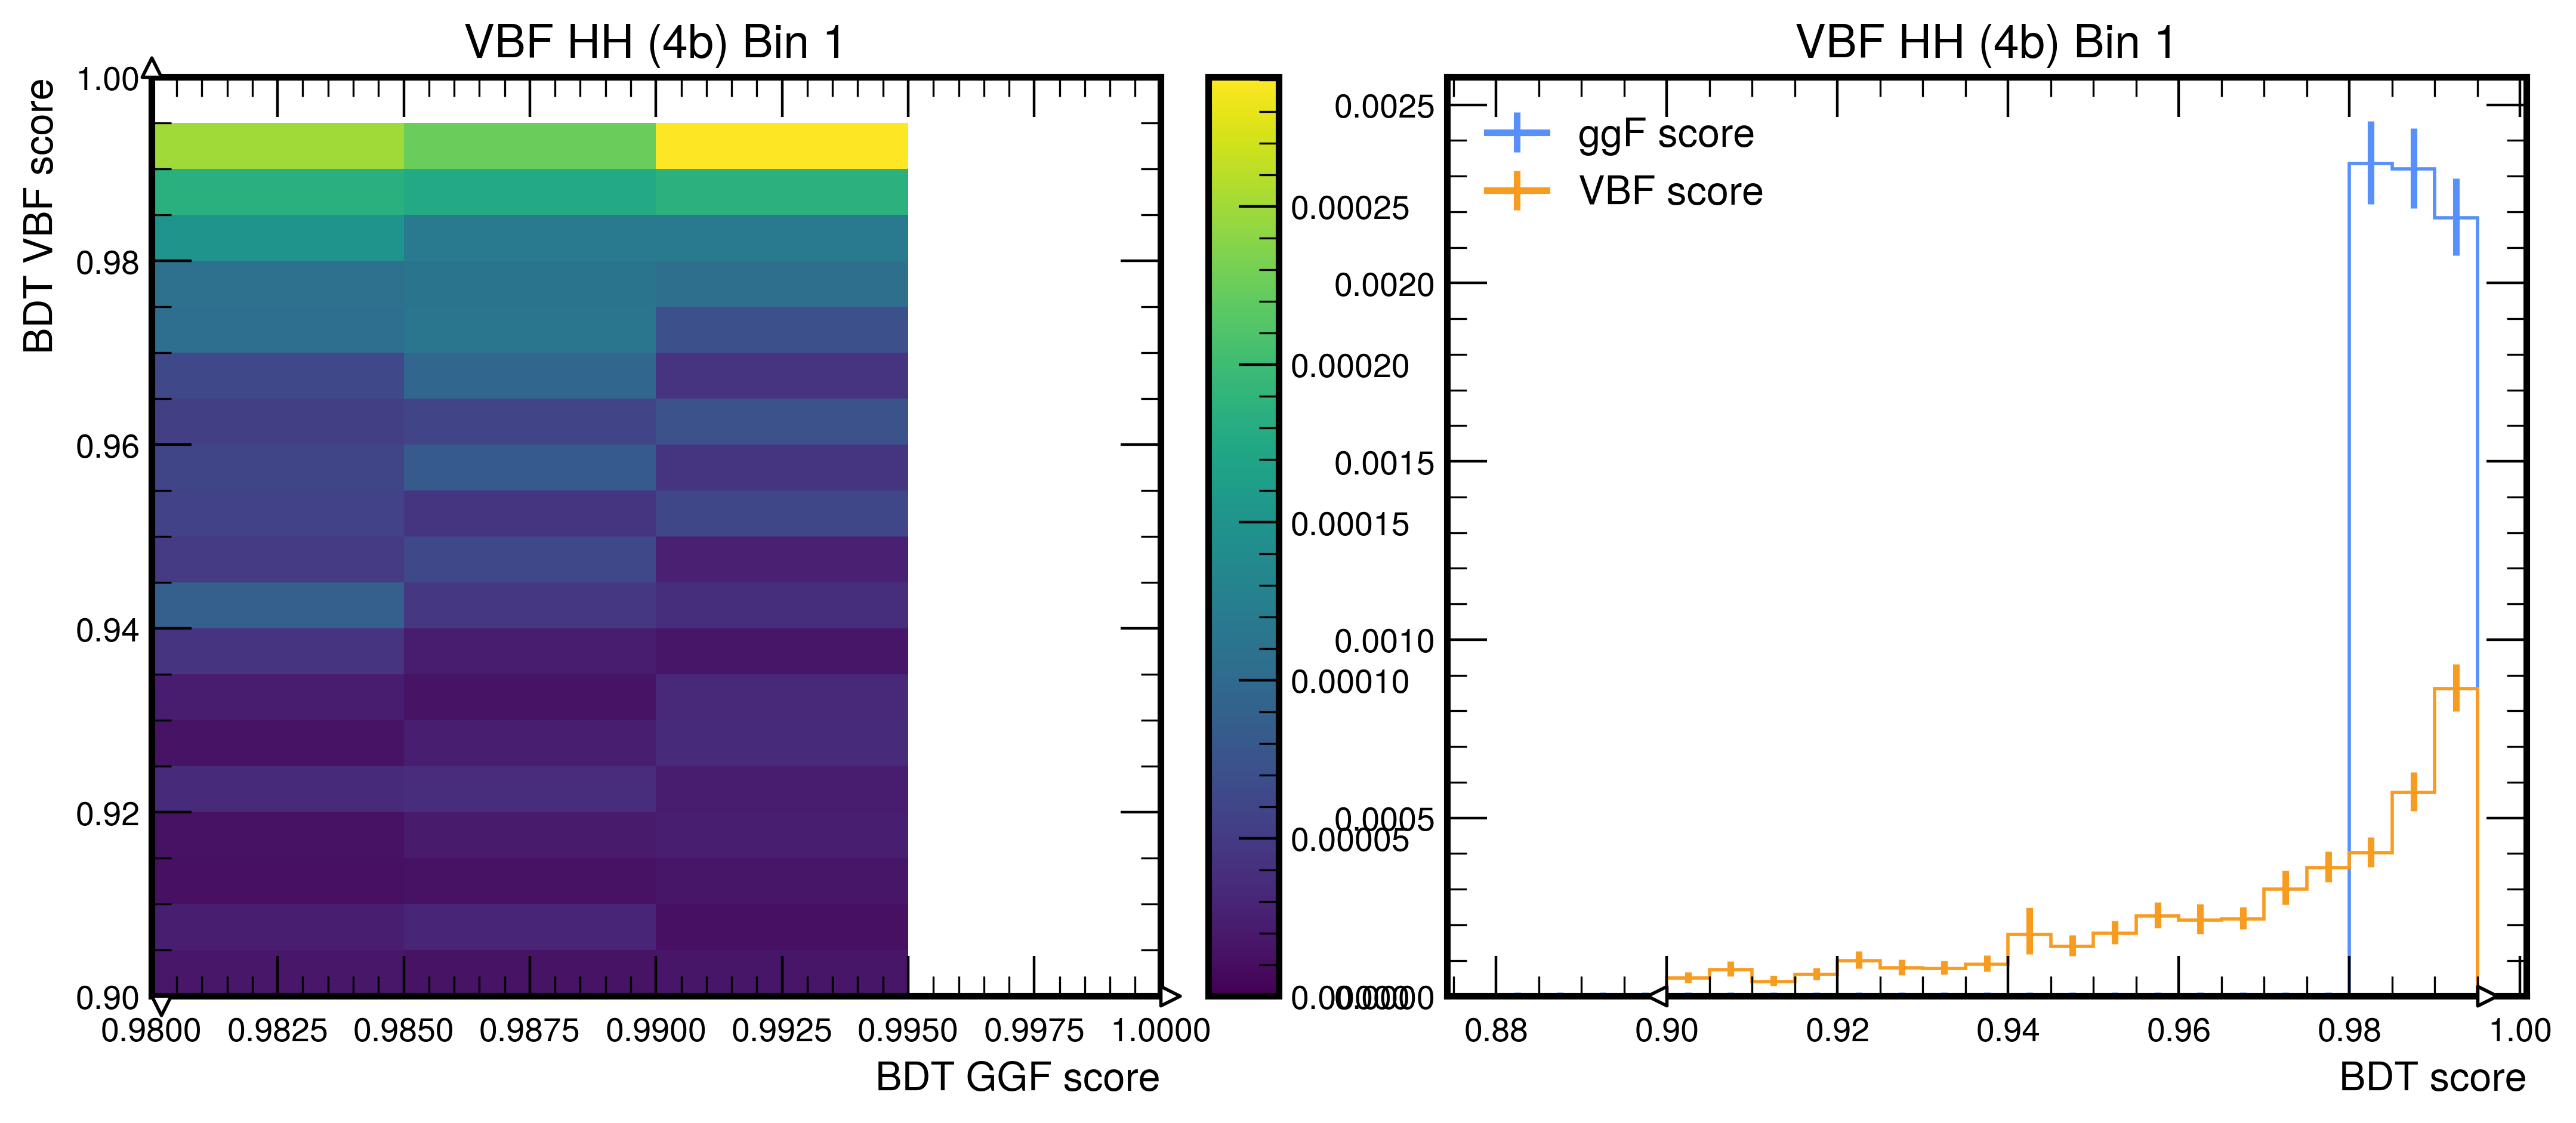

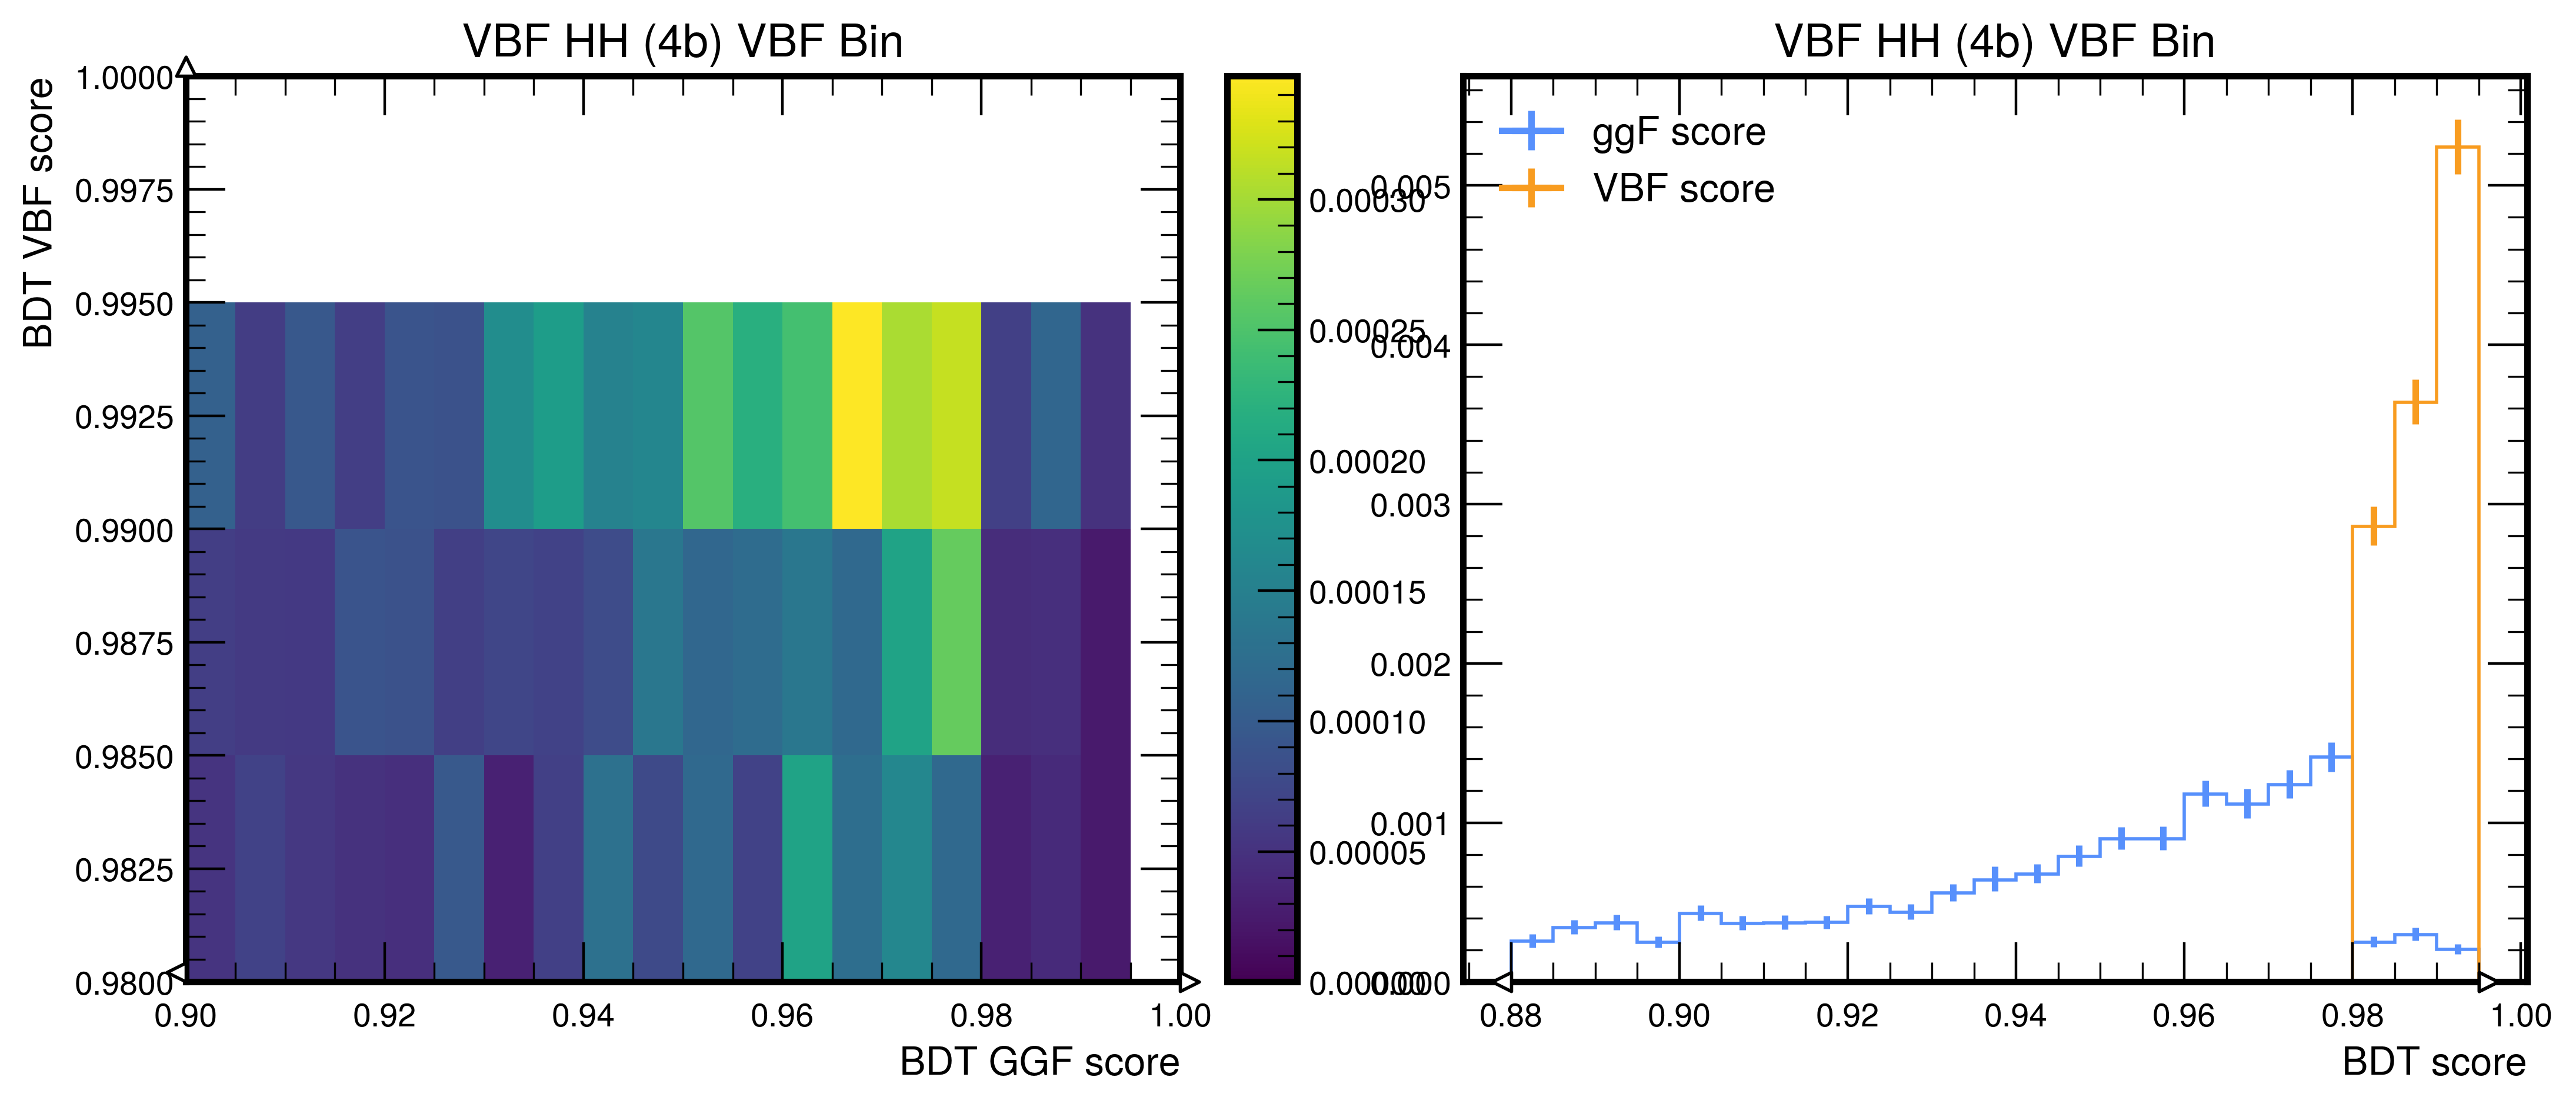

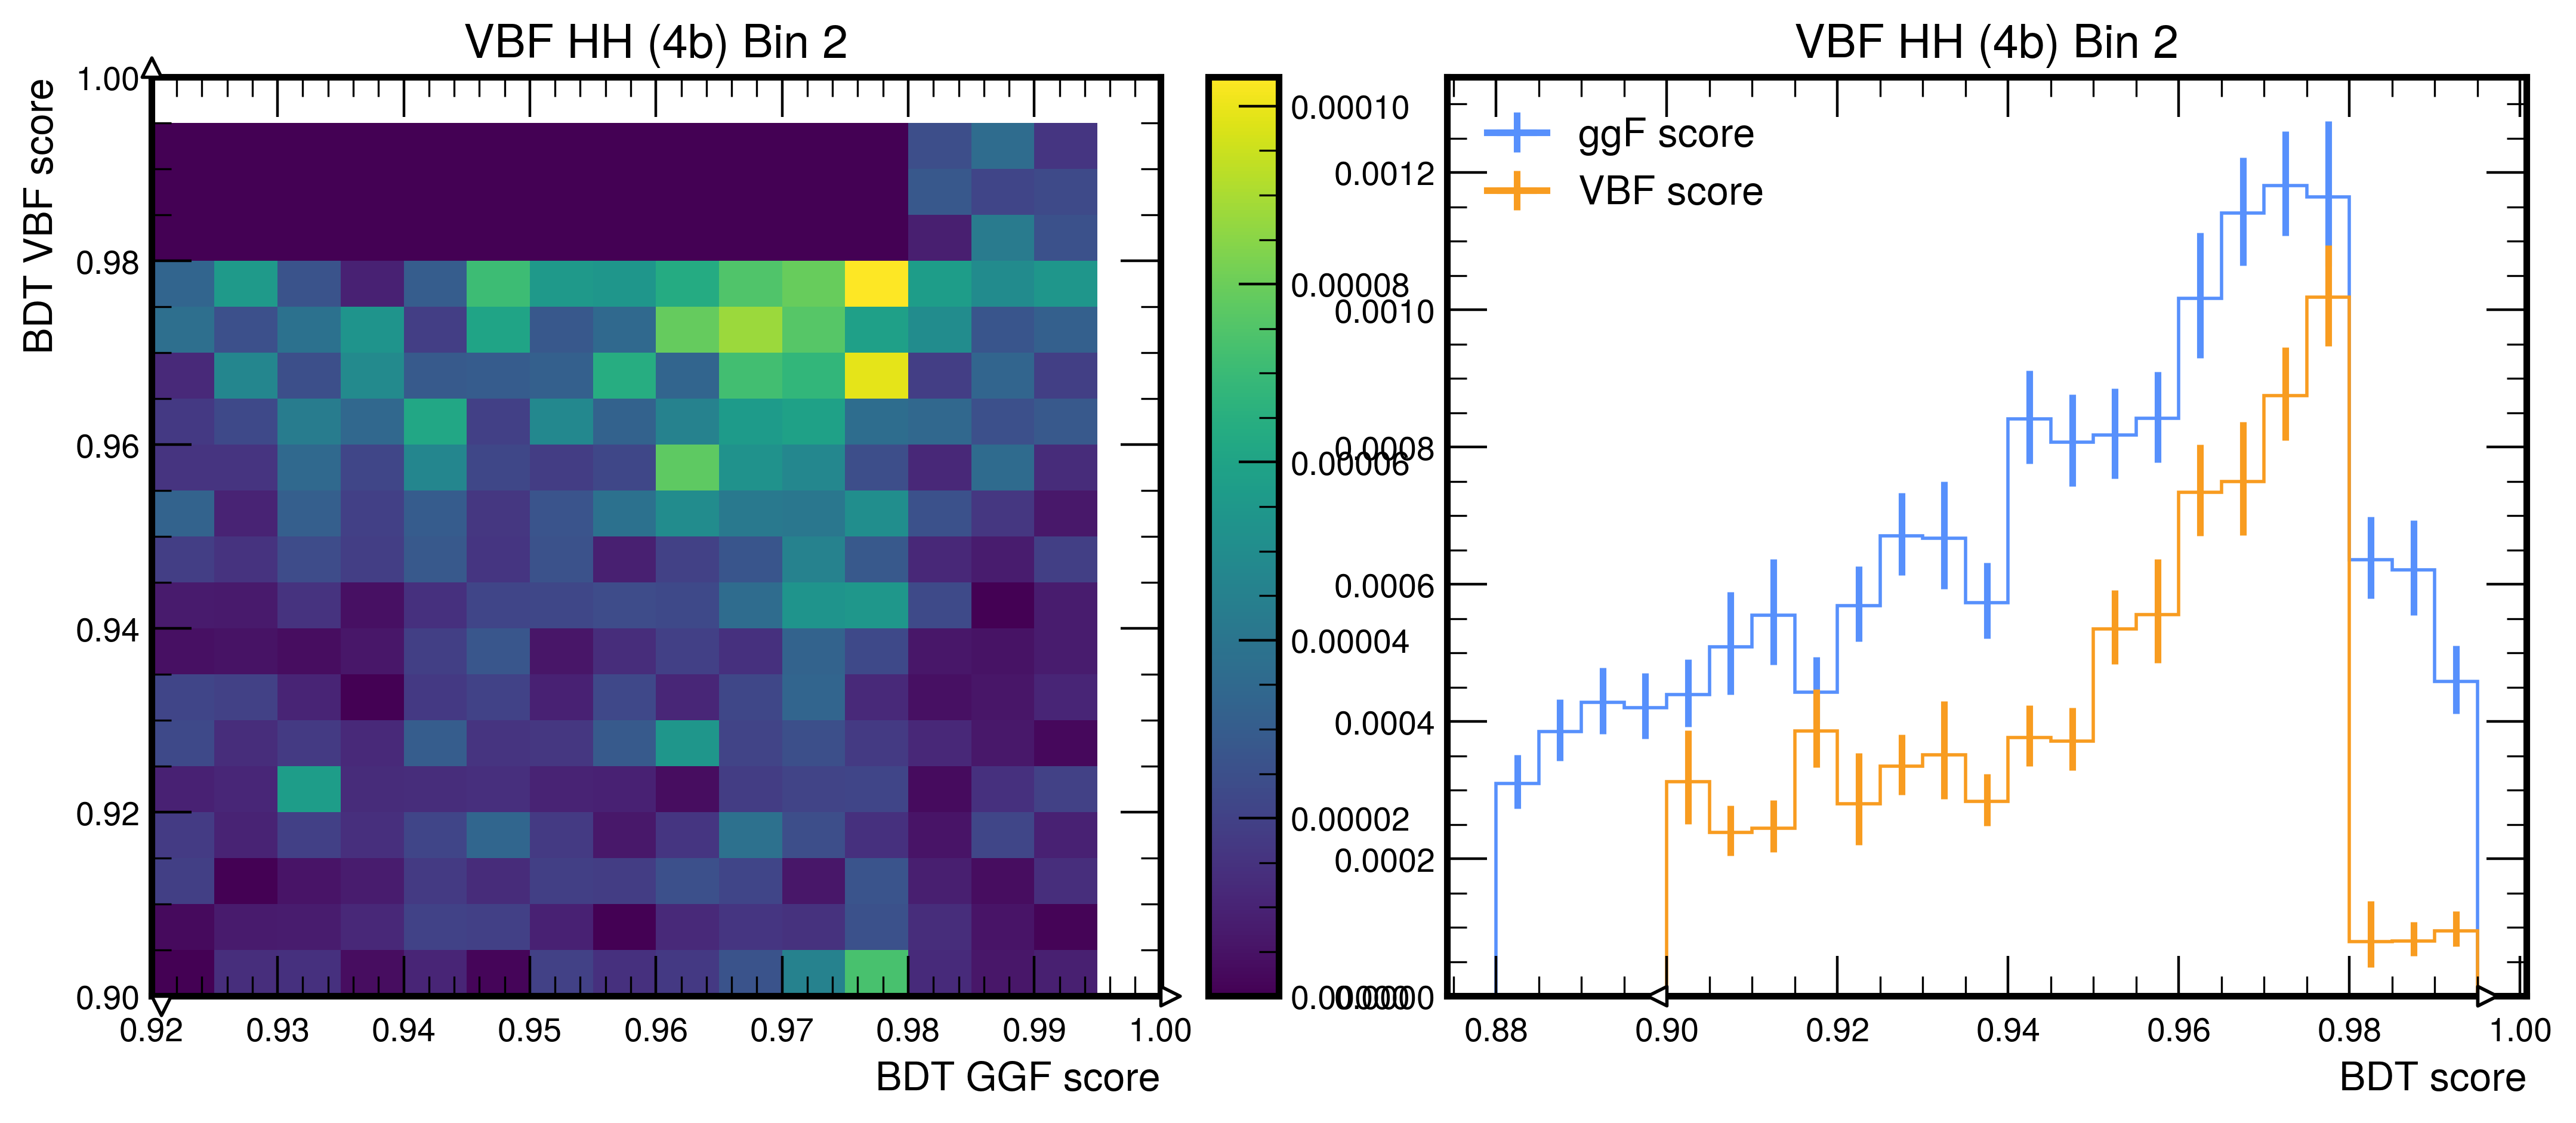

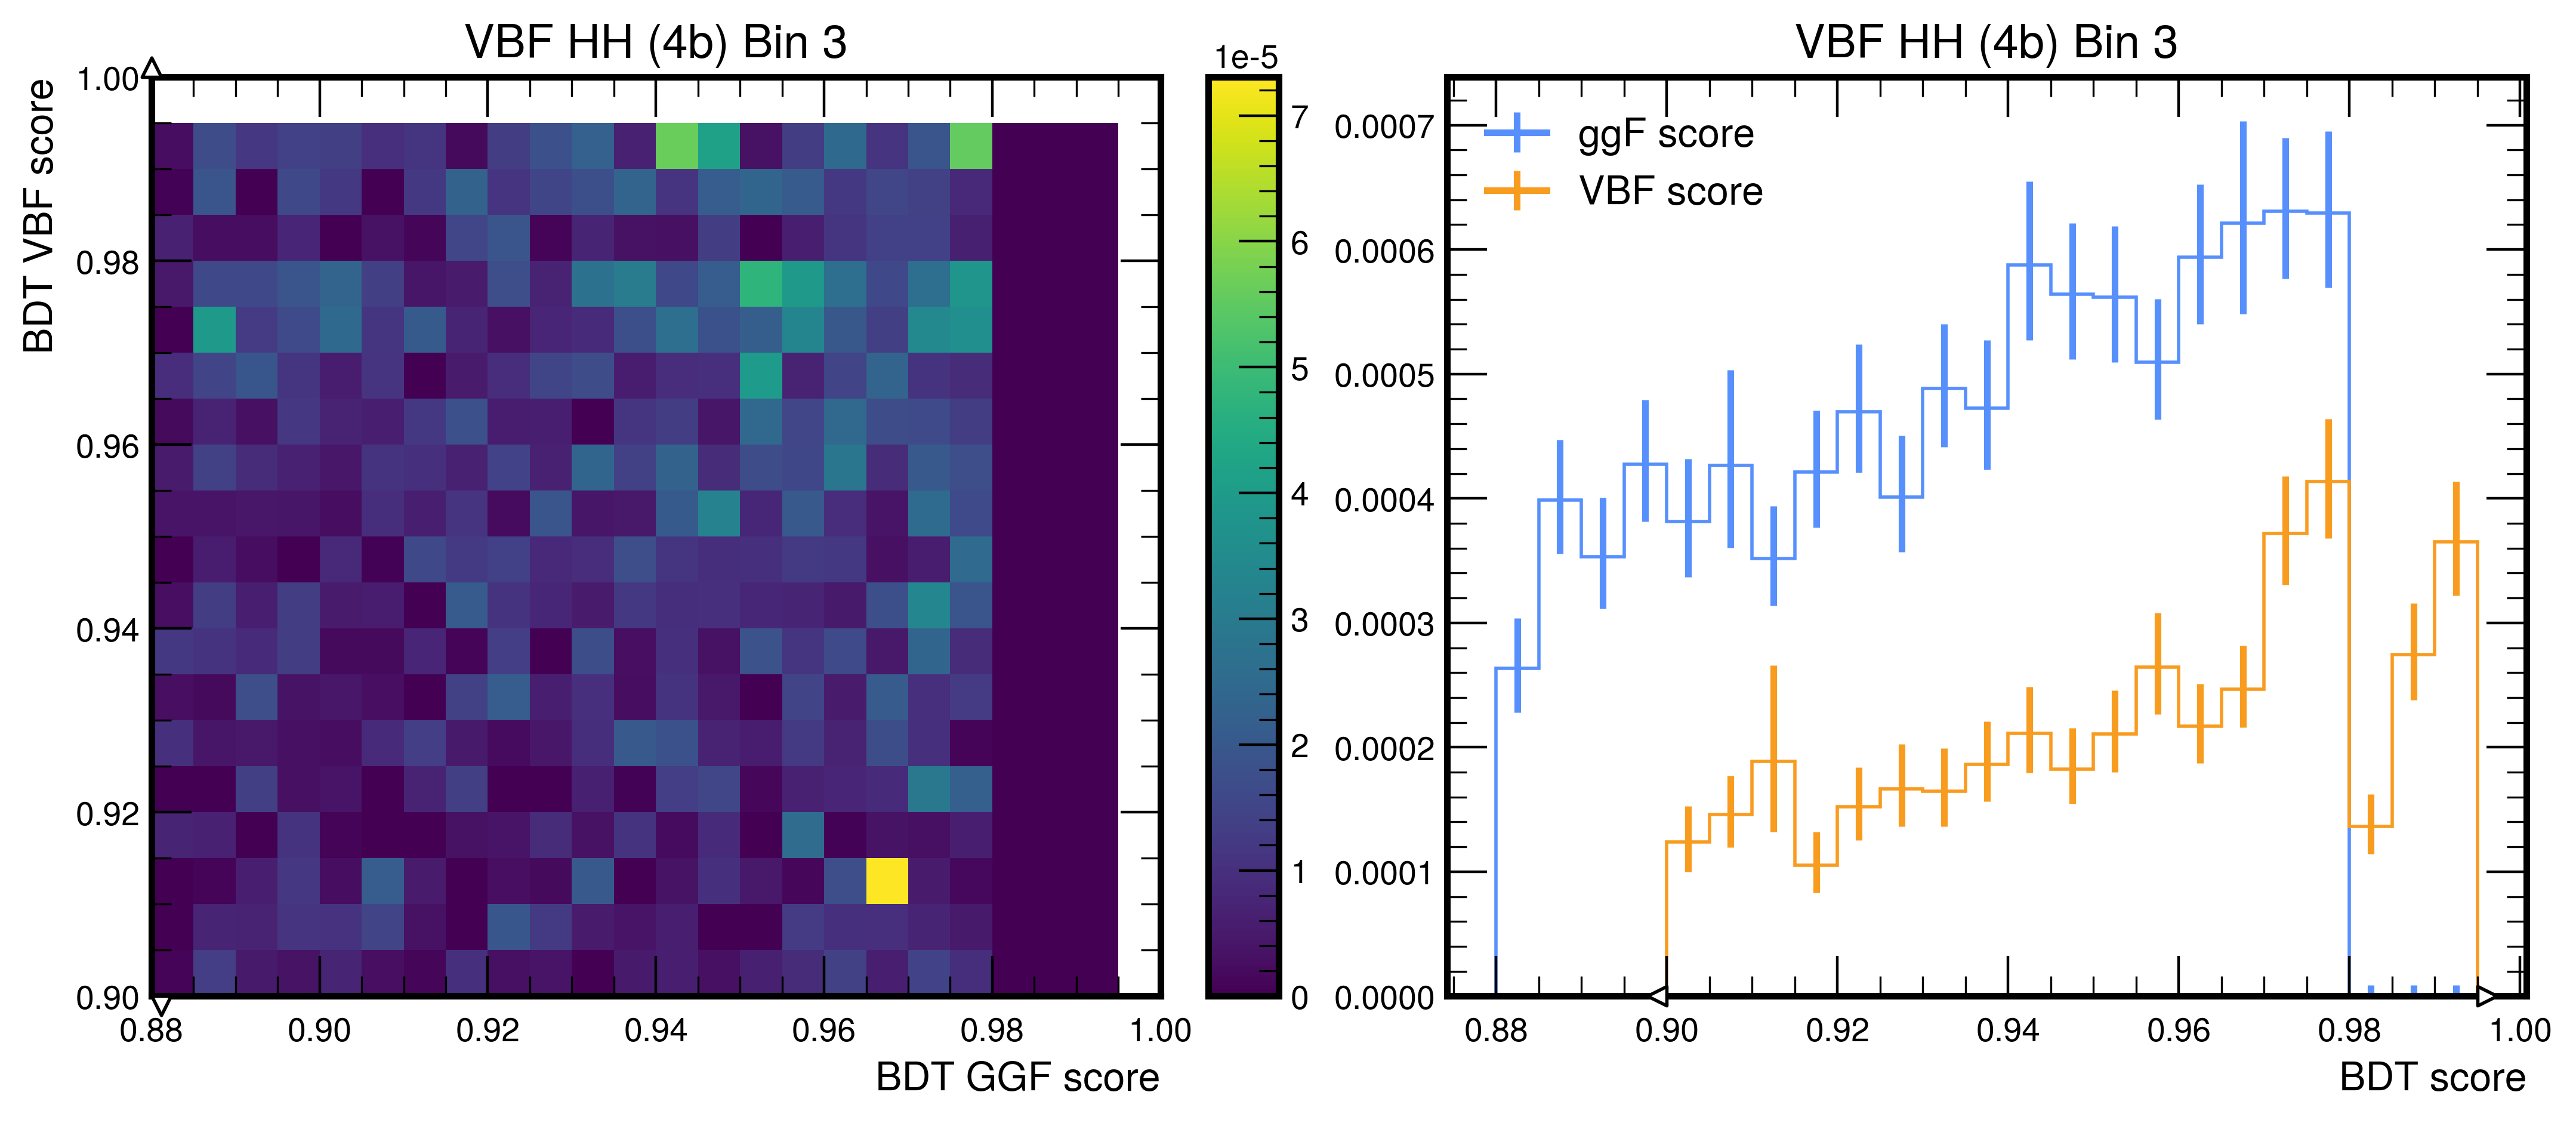

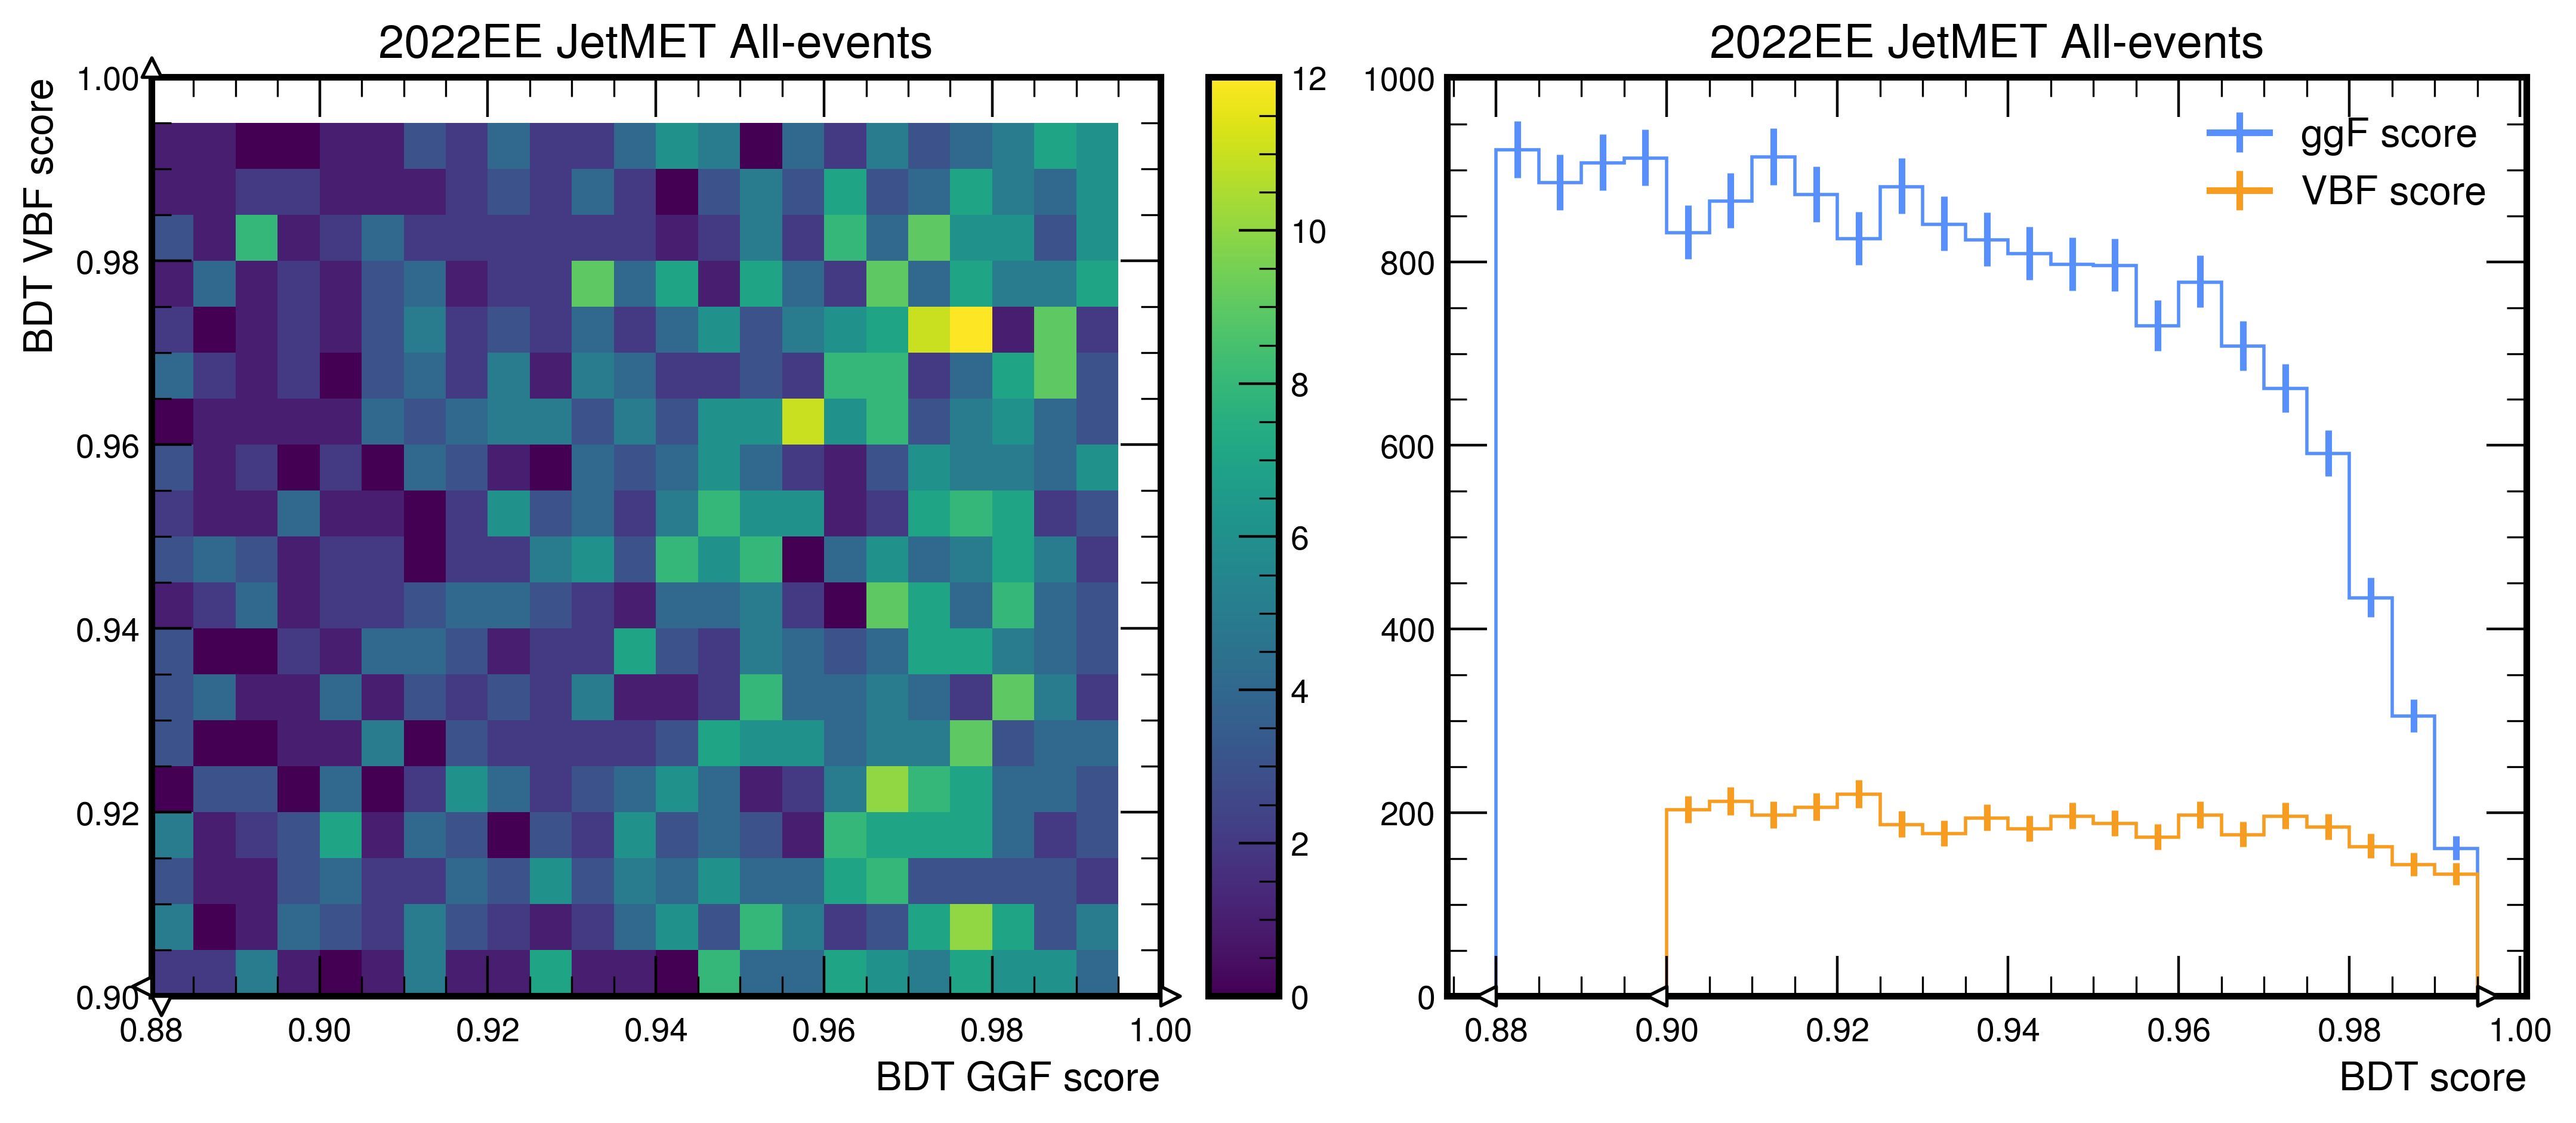

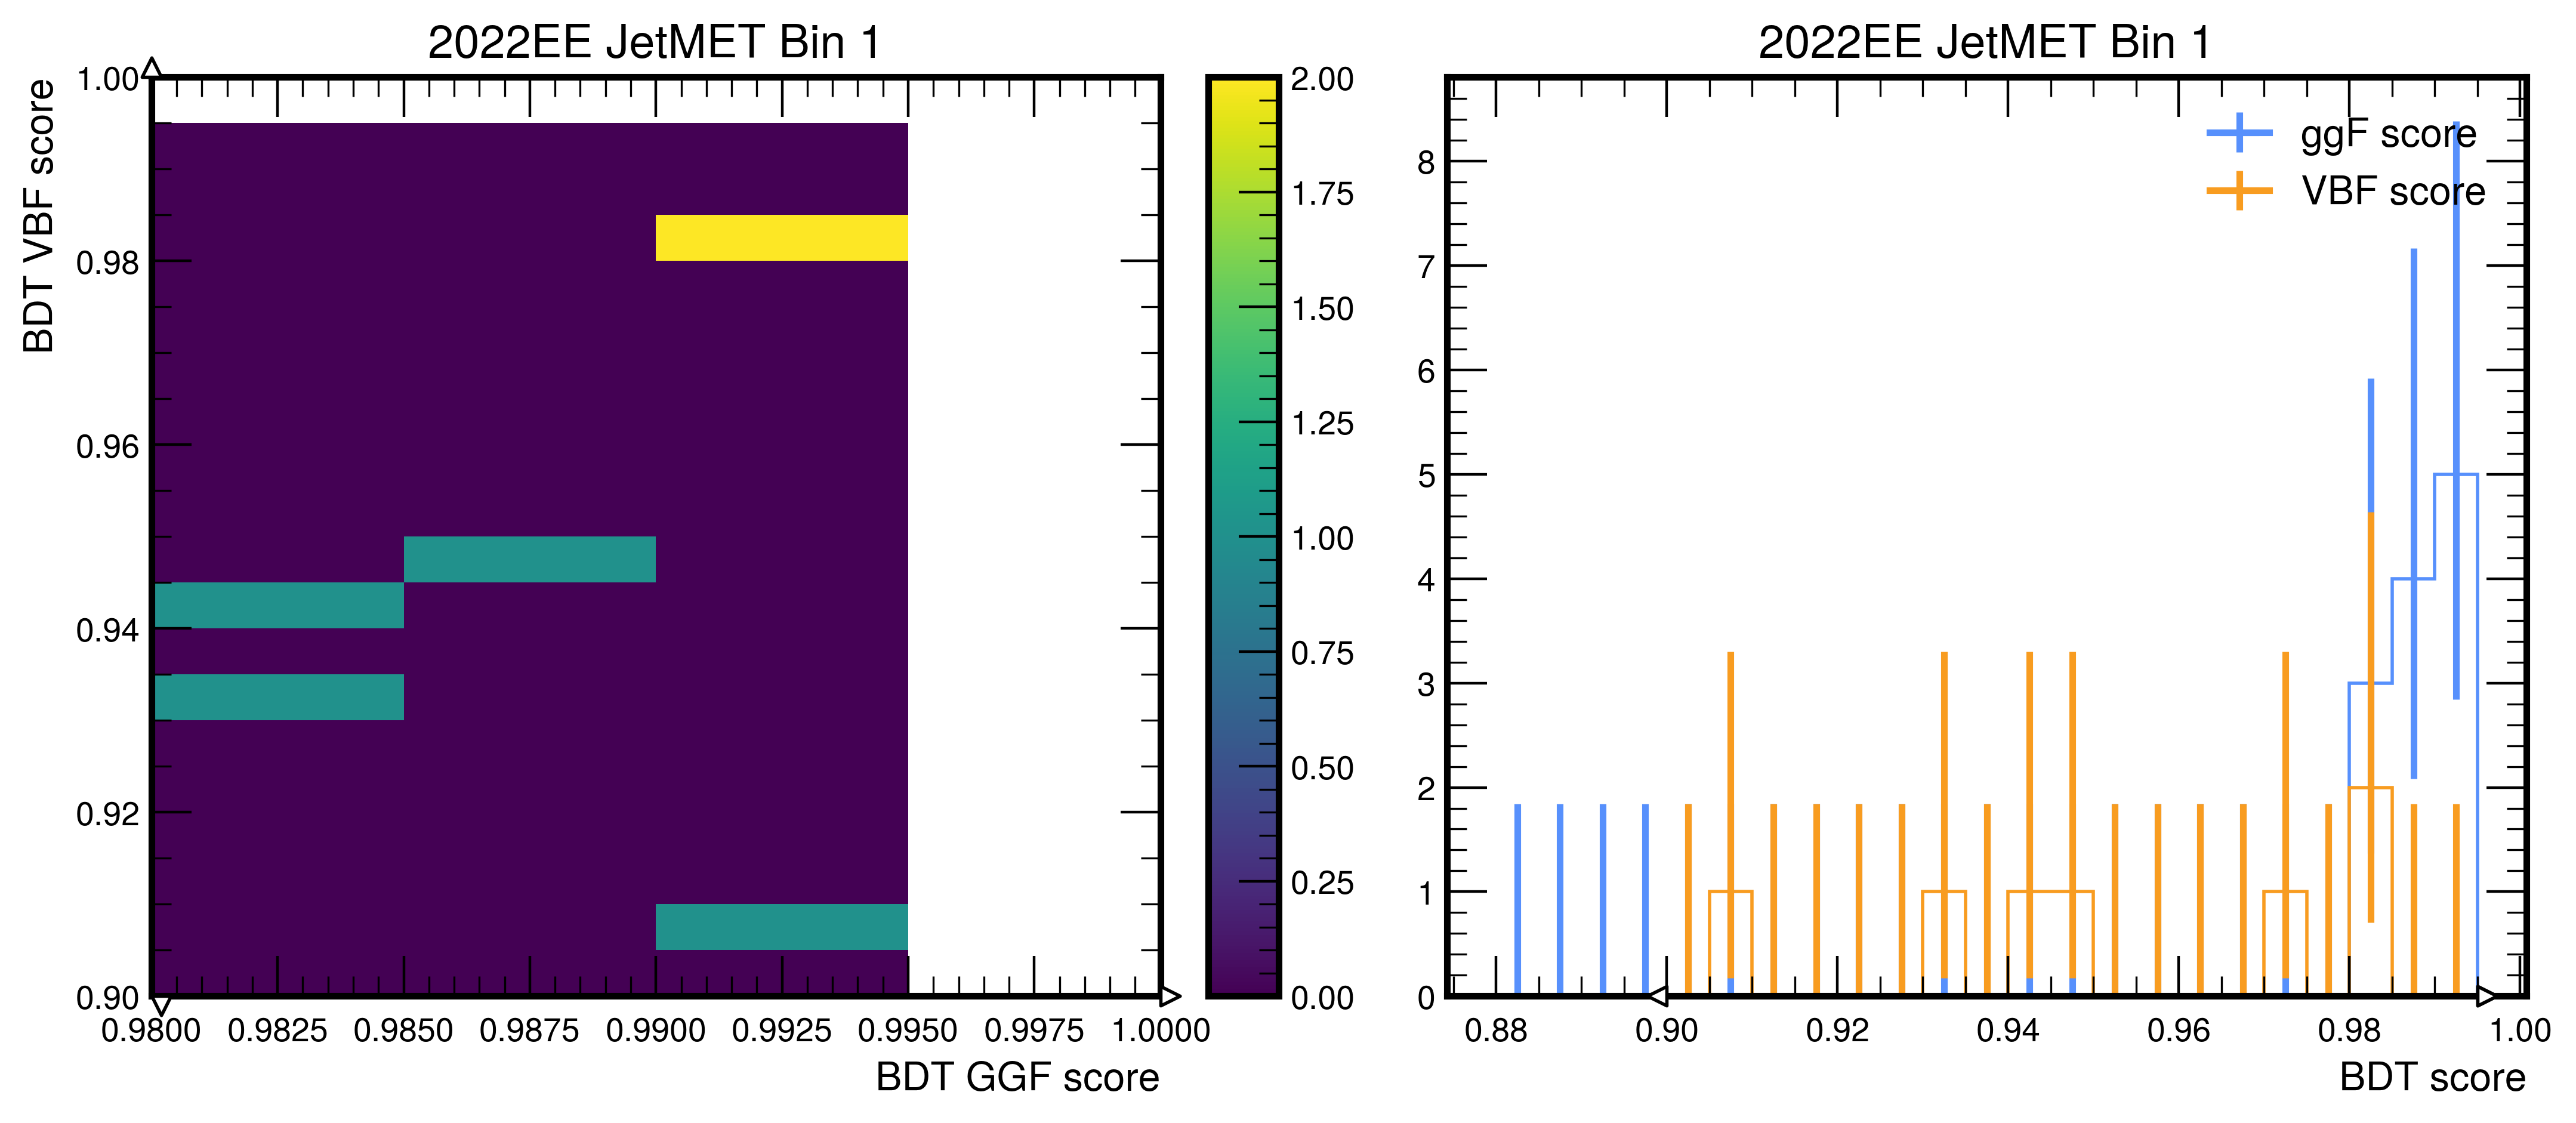

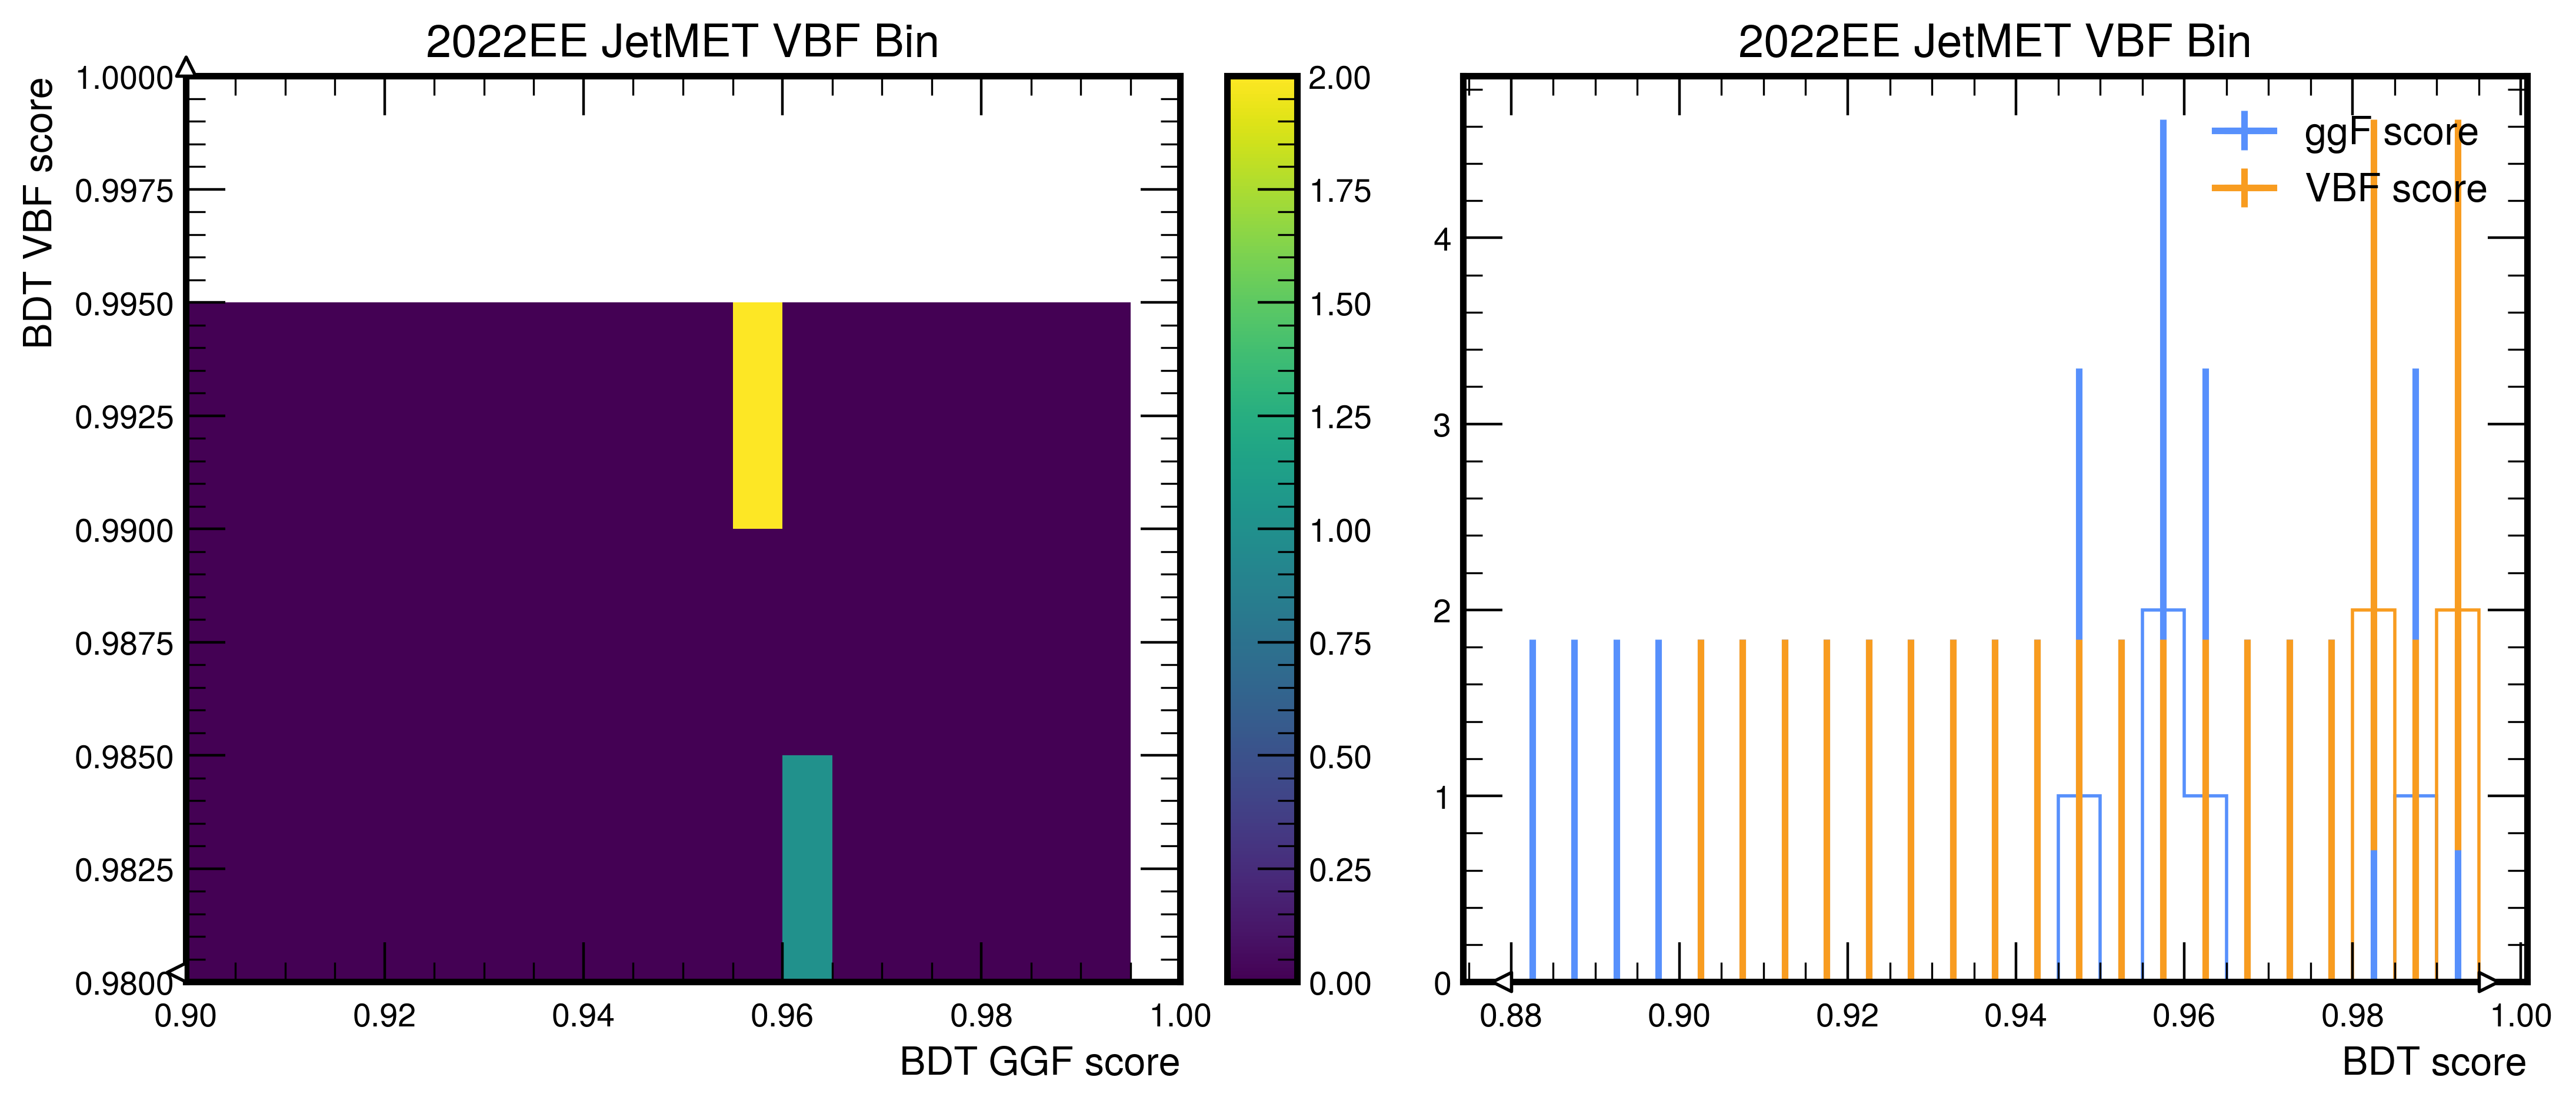

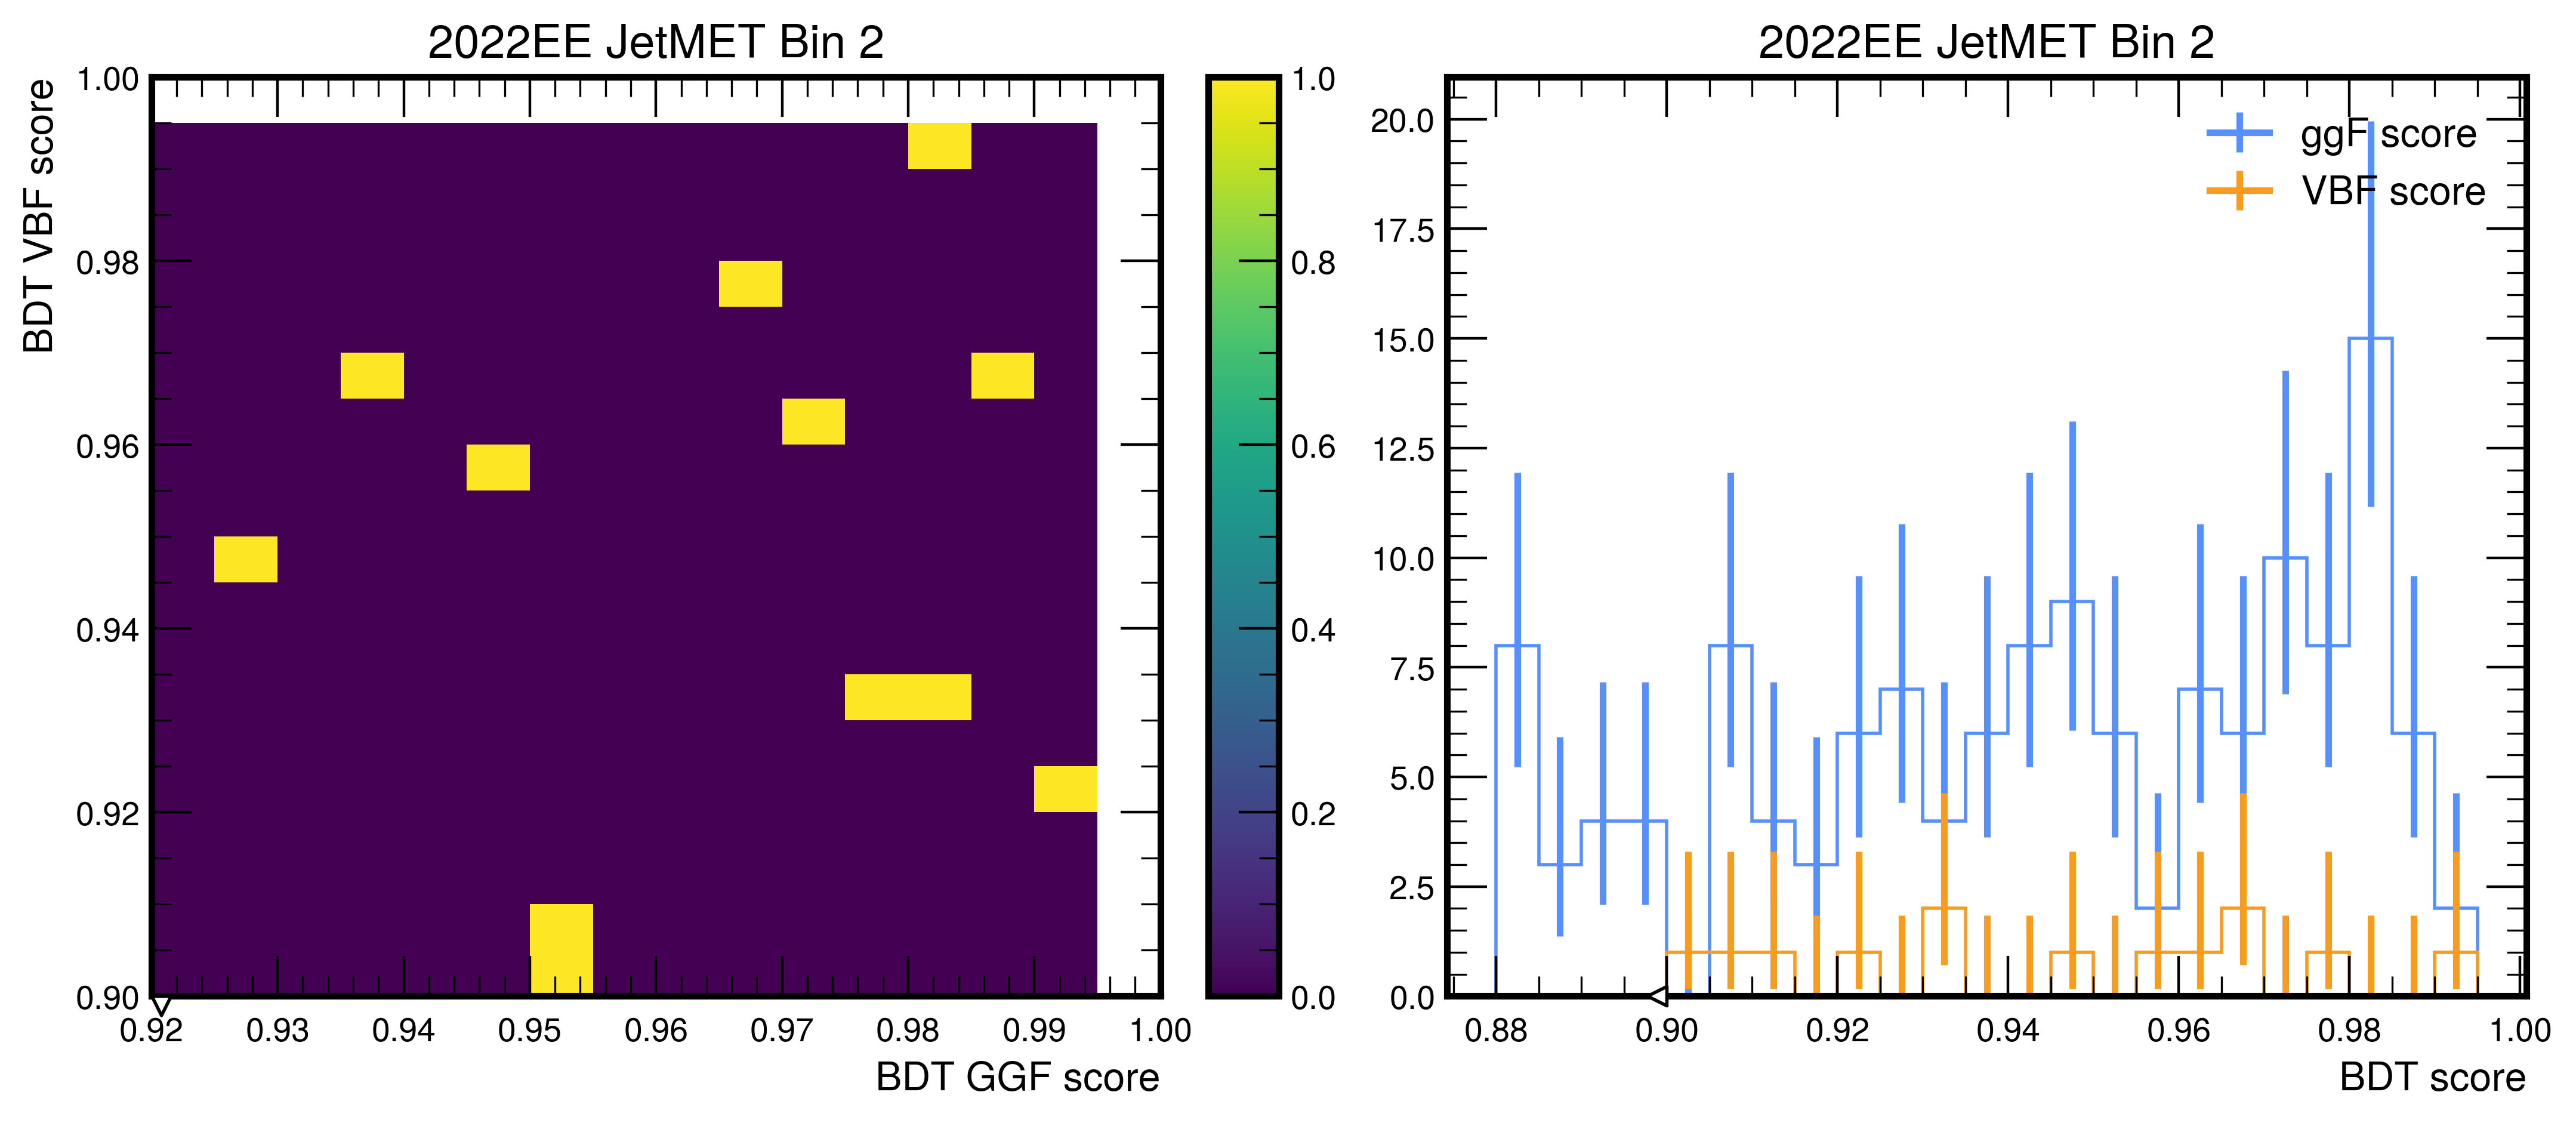

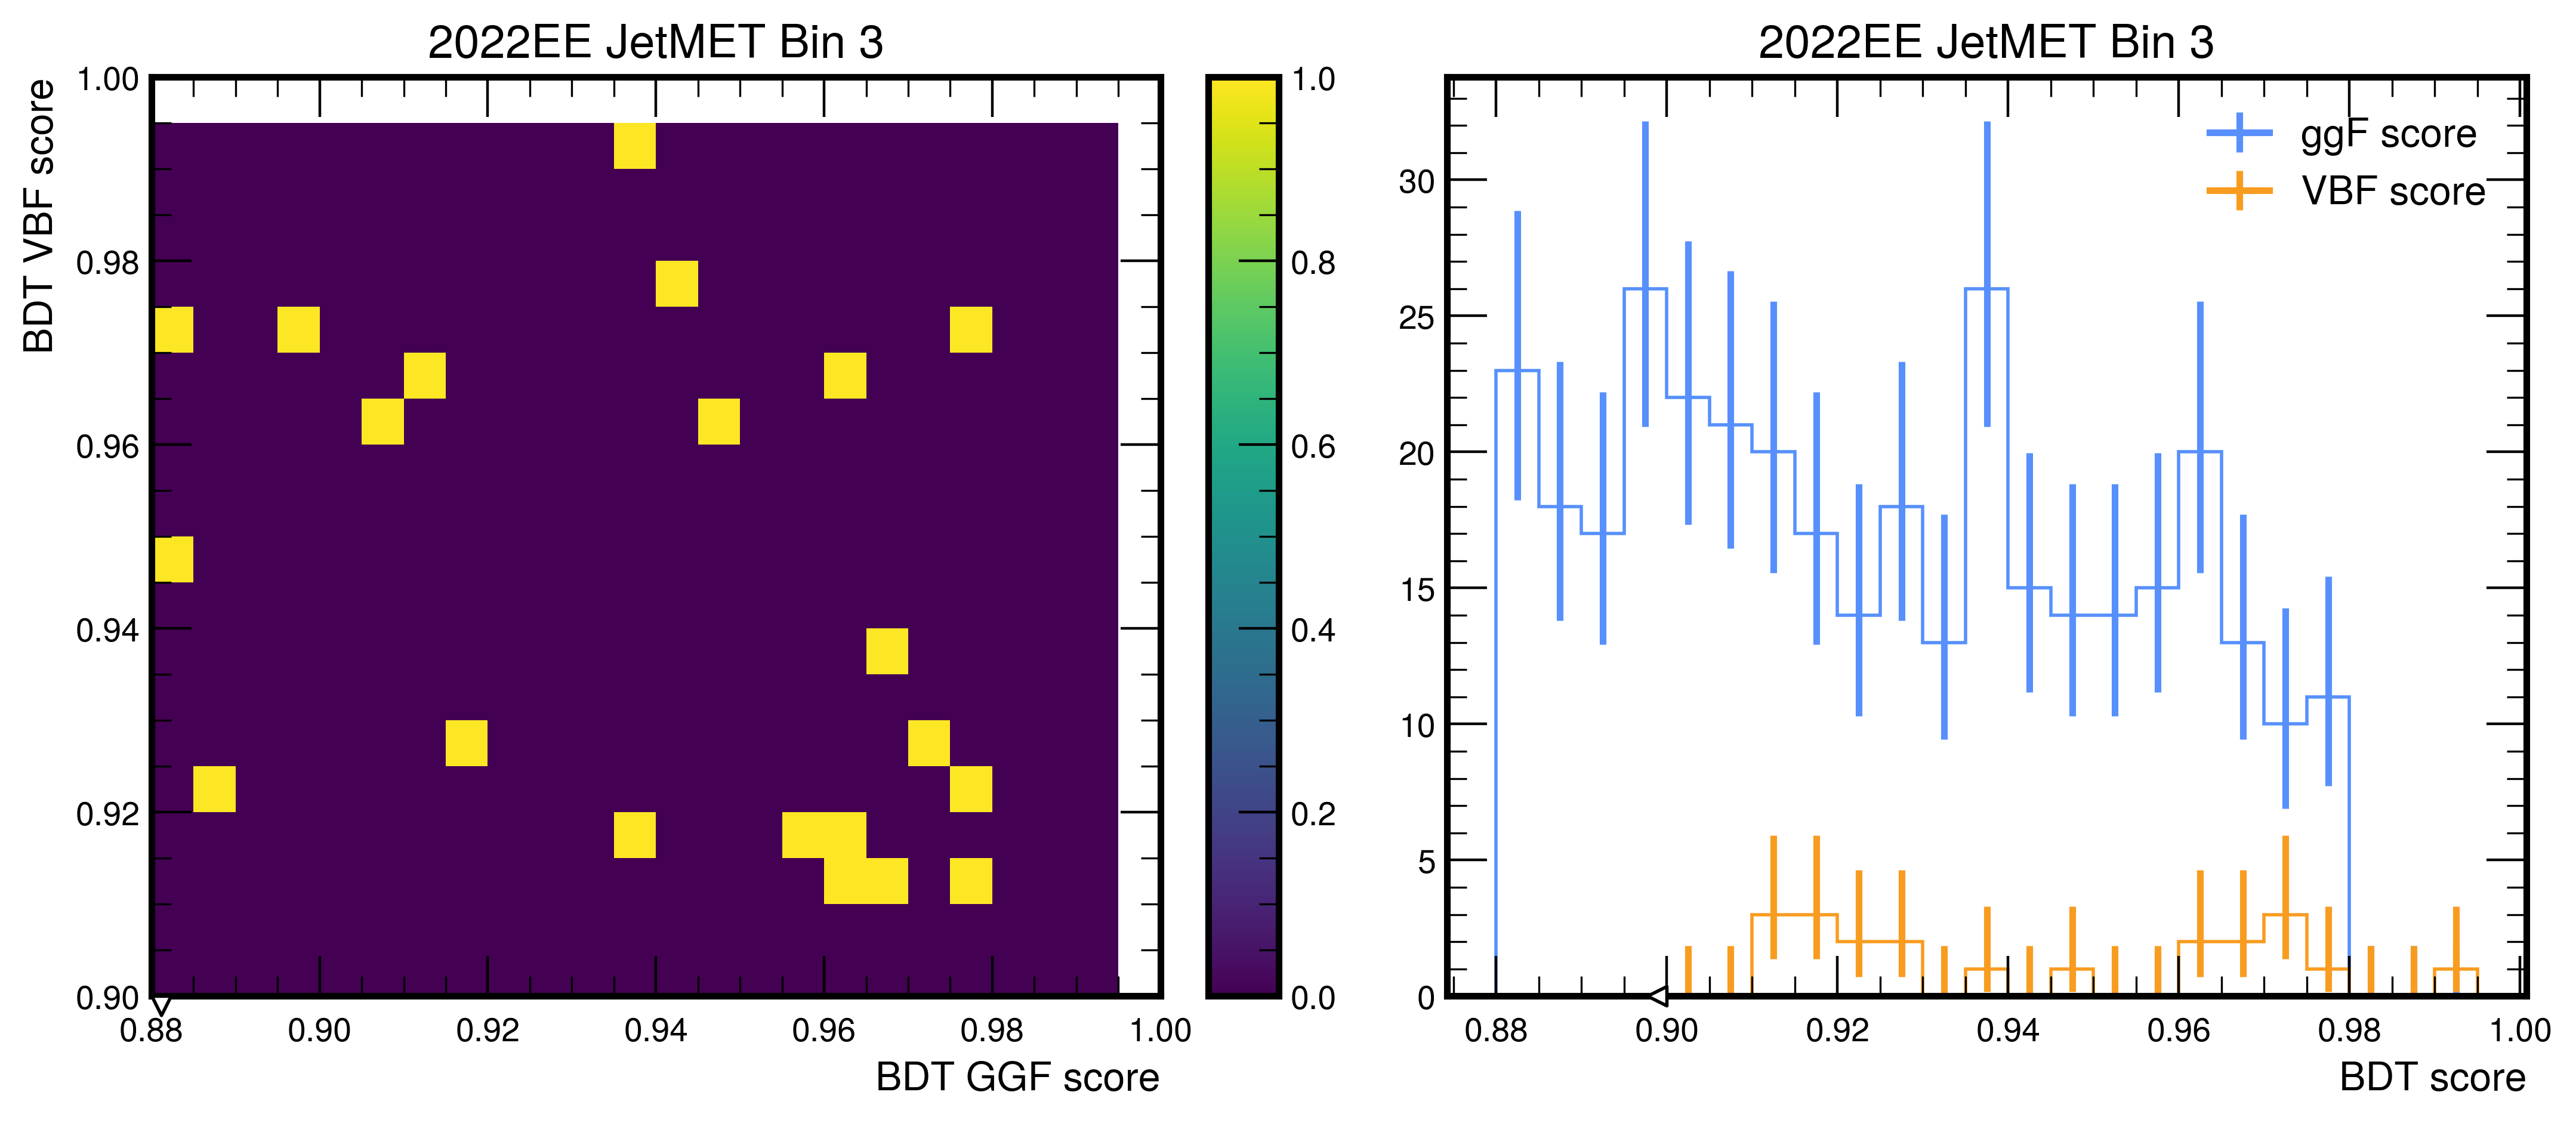

In [9]:
labels = {
    "hh4b": "ggF HH (4b)",
    "vbfhh4b": "VBF HH (4b)",
    "data": "2022EE JetMET",
}
cat_labels = {
    "all": "All-events",
    "bin1": "Bin 1",
    "vbf": "VBF Bin",
    "bin2": "Bin 2",
    "bin3": "Bin 3",
}
ggfbdt_lims = {
    "all": [0.88, 1],
    "bin1": [0.98, 1],
    "vbf": [0.9, 1],
    "bin2": [0.92, 1],
    "bin3": [0.88, 1],
}
vbfbdt_lims = {
    "all": [0.9, 1],
    "bin1": [0.9, 1],
    "vbf": [0.98, 1],
    "bin2": [0.9, 1],
    "bin3": [0.9, 1],
}
os.system("mkdir -p /home/users/cmantill/hh/HH4b/plots/PostProcess/bdt_correlation/")
bdt_axis = hist.axis.Variable(
    list(np.arange(0.88, 1, 0.005)), name="bdt_ggf", label="BDT GGF score"
)
bdt_vbf_axis = hist.axis.Variable(
    list(np.arange(0.9, 1, 0.005)), name="bdt_vbf", label="BDT VBF score"
)
cat_axis = hist.axis.StrCategory([], name="category", growth=True)

for key, events in events_combined.items():

    h_bdt = hist.Hist(bdt_axis, bdt_vbf_axis, cat_axis, storage=hist.storage.Weight())

    mask_vbf = (events["bdt_score_vbf"] > 0.98) & (events["H2TXbb"] > 0.95)
    mask_t2xbb = events["H2TXbb"] > 0.975
    mask_bin1 = (events["H2TXbb"] > 0.975) & (events["bdt_score"] > 0.98)
    mask_vbf = mask_vbf & ~(mask_bin1)
    mask_bin2 = (
        (~mask_bin1)
        & ~(mask_vbf)
        & (
            ((events["H2TXbb"] > 0.975) & (events["bdt_score"] > 0.88))
            | ((events["H2TXbb"] > 0.92) & (events["bdt_score"] > 0.98))
        )
    )
    mask_bin3 = (
        (~mask_bin1)
        & (~mask_bin2)
        & ~(mask_vbf)
        & ((events["H2TXbb"] > 0.92) & (events["bdt_score"] > 0.88))
    )

    h_bdt.fill(
        events["bdt_score"], events["bdt_score_vbf"], category="all", weight=events["weight"]
    )
    h_bdt.fill(
        events["bdt_score"][mask_bin1],
        events["bdt_score_vbf"][mask_bin1],
        category="bin1",
        weight=events["weight"][mask_bin1],
    )
    h_bdt.fill(
        events["bdt_score"][mask_vbf],
        events["bdt_score_vbf"][mask_vbf],
        category="vbf",
        weight=events["weight"][mask_vbf],
    )
    h_bdt.fill(
        events["bdt_score"][mask_bin2],
        events["bdt_score_vbf"][mask_bin2],
        category="bin2",
        weight=events["weight"][mask_bin2],
    )
    h_bdt.fill(
        events["bdt_score"][mask_bin3],
        events["bdt_score_vbf"][mask_bin3],
        category="bin3",
        weight=events["weight"][mask_bin3],
    )

    icat = 0
    for cat, cat_label in cat_labels.items():
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        hep.hist2dplot(h_bdt[{"category": cat}], ax=ax[0])
        ax[0].set_title(labels[key] + f" {cat_label}", fontsize=14)
        ax[0].set_xlim(ggfbdt_lims[cat])
        ax[0].set_ylim(vbfbdt_lims[cat])

        hep.histplot(h_bdt[{"bdt_vbf": sum, "category": cat}], ax=ax[1], label="ggF score")
        hep.histplot(h_bdt[{"bdt_ggf": sum, "category": cat}], ax=ax[1], label="VBF score")
        ax[1].legend(fontsize=12)
        ax[1].set_xlabel("BDT score")
        ax[1].set_title(labels[key] + f" {cat_label}", fontsize=14)
        icat += 1
        fig.savefig(f"../../../plots/PostProcess/bdt_correlation/{key}_{cat}.png")